In [1]:
# data analytics imports
import math
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy import stats
import scipy.sparse as sparse

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import matplotlib.units as units

# machine learning imports for predicting churn
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import auc, classification_report, roc_auc_score, accuracy_score, f1_score, roc_curve, confusion_matrix, precision_score, recall_score

# spark imports for recommendation system
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import *
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import Row

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

In [2]:
df1 = pd.read_csv('Dataset 1/Order and Demographic Data.txt', sep="|", header = 0)

In [3]:
df1.head()

,Customer Name,Order Number,Order Date,Order Channel,Order Store,Order Store Zip,Ship Channel,Ship Store,Ship Store Zip,Department,Product Category,Sales,Cost,Gross Profit,Qty,Customer Zip,Customer Age,Customer Children,Customer Residence Type,Customer Residence Unit,Customer Education,Customer Household Composition,Customer Homeowner,Customer Household Income,Customer Segment,Customer Group,Customer Gender,Customer Marital Status
0,Customer 1,Order Number 1248752,2020-02-12,Order Channel 1,Order Store 18,Order Store Zip 26,Ship Channel 2,Ship Store 114,Ship Store Zip 55,Department 10,Product Category 19,80.308,40.936,39.372,3,Customer Zip 10660,Customer Age 26,Customer Children 1,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 5,Customer Household Composition 3,Customer Homeowner 1,Customer Household Income 12,Customer Segment 37,Customer Group 13,Customer Gender 2,Customer Marital Status 1
1,Customer 1,Order Number 1248752,2020-02-12,Order Channel 1,Order Store 18,Order Store Zip 26,Ship Channel 6,Ship Store 63,Ship Store Zip 42,Department 10,Product Category 19,80.308,40.936,39.372,3,Customer Zip 10660,Customer Age 26,Customer Children 1,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 5,Customer Household Composition 3,Customer Homeowner 1,Customer Household Income 12,Customer Segment 37,Customer Group 13,Customer Gender 2,Customer Marital Status 1
2,Customer 1,Order Number 125983,2019-05-14,Order Channel 4,Order Store 21,Order Store Zip 81,Ship Channel 6,Ship Store 21,Ship Store Zip 80,Department 10,Product Category 17,-101.983,-55.301,-46.682,-3,Customer Zip 10660,Customer Age 26,Customer Children 1,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 5,Customer Household Composition 3,Customer Homeowner 1,Customer Household Income 12,Customer Segment 37,Customer Group 13,Customer Gender 2,Customer Marital Status 1
3,Customer 1,Order Number 125983,2019-05-14,Order Channel 4,Order Store 21,Order Store Zip 81,Ship Channel 6,Ship Store 21,Ship Store Zip 80,Department 10,Product Category 17,-67.983,-20.417,-47.566,-3,Customer Zip 10660,Customer Age 26,Customer Children 1,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 5,Customer Household Composition 3,Customer Homeowner 1,Customer Household Income 12,Customer Segment 37,Customer Group 13,Customer Gender 2,Customer Marital Status 1
4,Customer 1,Order Number 125983,2019-05-14,Order Channel 4,Order Store 21,Order Store Zip 81,Ship Channel 6,Ship Store 21,Ship Store Zip 80,Department 10,Product Category 17,-61.183,-21.675,-39.508,-3,Customer Zip 10660,Customer Age 26,Customer Children 1,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 5,Customer Household Composition 3,Customer Homeowner 1,Customer Household Income 12,Customer Segment 37,Customer Group 13,Customer Gender 2,Customer Marital Status 1


In [19]:
df1.columns

Index(['Customer Name', 'Order Number', 'Order Date', 'Order Channel',
       'Order Store', 'Order Store Zip', 'Ship Channel', 'Ship Store',
       'Ship Store Zip', 'Department', 'Product Category', 'Sales', 'Cost',
       'Gross Profit', 'Qty', 'Customer Zip', 'Customer Age',
       'Customer Children', 'Customer Residence Type',
       'Customer Residence Unit', 'Customer Education',
       'Customer Household Composition', 'Customer Homeowner',
       'Customer Household Income', 'Customer Segment', 'Customer Group',
       'Customer Gender', 'Customer Marital Status'],
      dtype='object')

In [4]:
# generate a variable representing SKU
df1['SKU'] = 'SKU'+df1['Department'].str[11::]+df1['Product Category'].str[17::]

In [139]:
# remove cases only when all values are 0 to cancel out some returned orders
group = df1.groupby(['Order Number']).sum()
invoice = group[(group != 0).any(1)].index.to_list()
# 1898748 total; 1862867  any
df1Clean = df1[df1['Order Number'].isin(invoice)]
df1Clean.describe().round(2)

,Sales,Cost,Gross Profit,Qty
count,4879872.00,4879872.00,4879872.00,4879872.00
mean,62.97,23.10,39.87,2.50
std,75.97,26.78,54.67,1.88
min,-1368.50,-613.50,-977.57,-30.00
25%,37.38,14.93,16.73,3.00
50%,61.20,22.83,37.23,3.00
75%,96.88,35.28,64.31,3.00
max,3825.00,2039.15,3224.22,450.00


# Exploratory Data Analysis

Correlation Matrix

In [1]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [9]:
rho = df1.corr().round(4)
pval = calculate_pvalues(df1) # toto_tico's answer
# create three masks
r1 = rho.applymap(lambda x: '{}*'.format(x))
r2 = rho.applymap(lambda x: '{}**'.format(x))
r3 = rho.applymap(lambda x: '{}***'.format(x))
# apply them where appropriate
rho = rho.mask(pval<=0.05, r1)
rho = rho.mask(pval<=0.01, r2)
#rho1 = rho15.mask(pval<=0.01,r3)
rho

,Sales,Cost,Gross Profit,Qty
Sales,1.0**,0.8649**,0.9692**,0.6915**
Cost,0.8649**,1.0**,0.7147**,0.6879**
Gross Profit,0.9692**,0.7147**,1.0**,0.6262**
Qty,0.6915**,0.6879**,0.6262**,1.0**


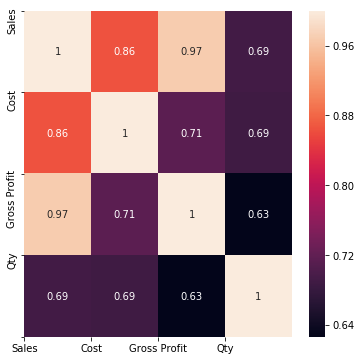

In [7]:
#Plot figsize
fig, ax = plt.subplots(figsize=(6, 6))
corr = df1.corr()
#Generate Heat Map, allow annotations
sns.heatmap(corr, annot = True)
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)+1), corr.columns);
#show plot
plt.show()

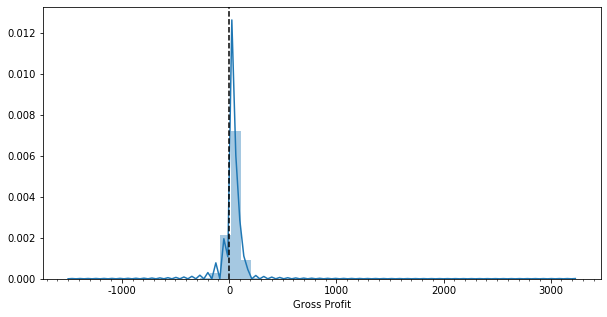

In [45]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.distplot(df1['Gross Profit']);
plt.axvline(0, color="k", linestyle="--");
# Make a plot with major ticks that are multiples of 1000 and minor ticks that
# are multiples of 100.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(100))

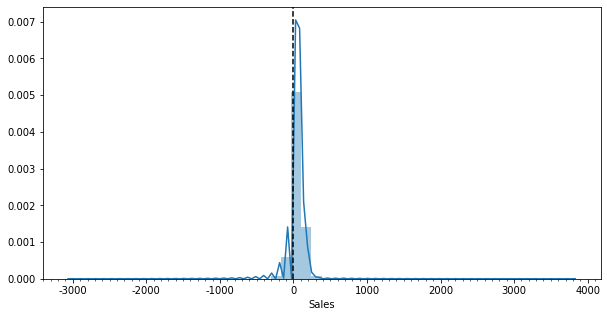

In [46]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.distplot(df1['Sales'])
plt.axvline(0, color="k", linestyle="--")
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(100))

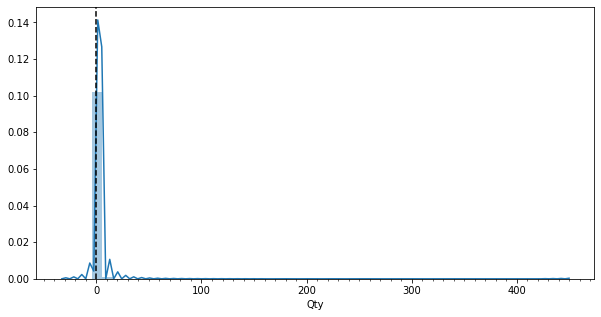

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.distplot(df1['Qty'])
plt.axvline(0, color="k", linestyle="--")
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(10))

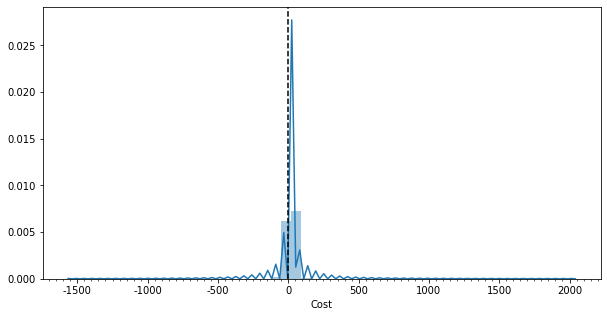

In [49]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.distplot(df1['Cost'])
plt.axvline(0, color="k", linestyle="--")
ax.xaxis.set_major_locator(MultipleLocator(500))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(50))

In [ ]:
values = ['Customer Name', 'Sales', 'Cost', 'Gross Profit', 'Qty']
df1values = df1[values]
df1Customer = pd.DataFrame()
for i in df1values['Customer Name'].drop_duplicates():
    df_tem = df1values[df1values['Customer Name'] == i]
    df_tem.append(df_tem.sum().rename(i))
    df1Customer = pd.concat([df1Customer, df_tem])

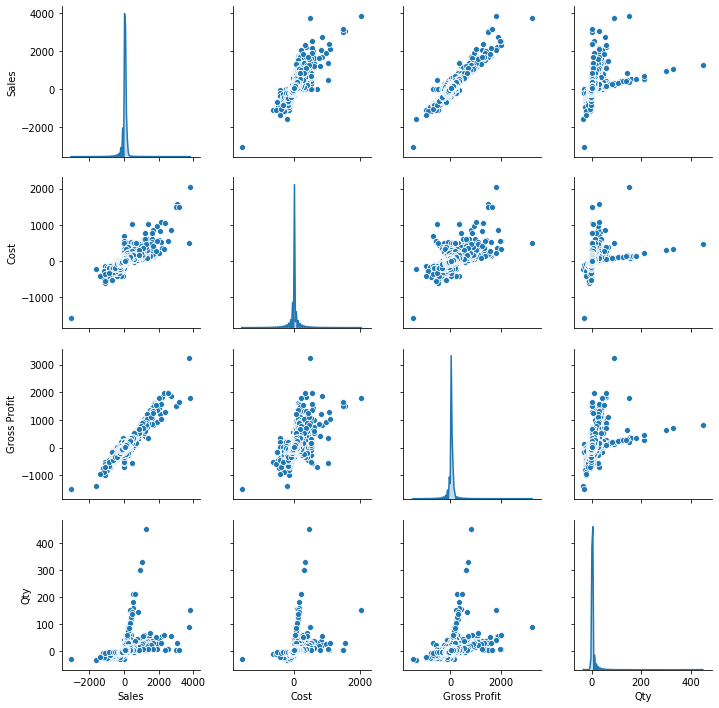

In [97]:
sns.pairplot(df1, diag_kind="kde", diag_kws=dict(shade=True, bw=.05, vertical=False) )

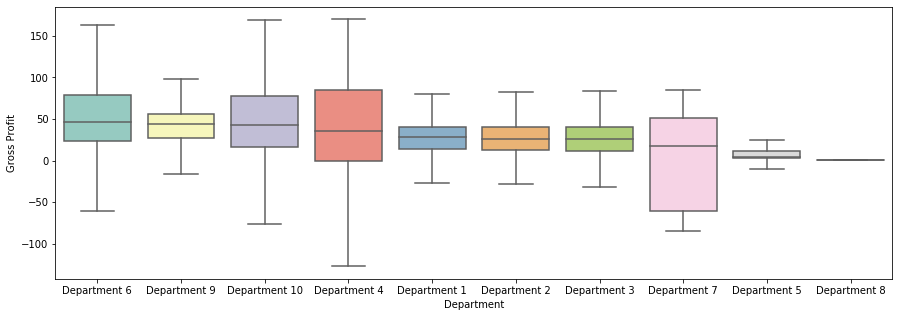

In [5]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x = "Department", y = "Gross Profit", data = df1, palette="Set3", showfliers=False,
           order = df1.groupby(by=["Department"])["Gross Profit"].median().sort_values(ascending=False).index)

In [62]:
customer[customer['Gross Profit'] == 0]

,Customer Name,Customer Zip,Customer Age,Customer Children,Customer Residence Type,Customer Residence Unit,Customer Education,Customer Household Composition,Customer Homeowner,Customer Household Income,Customer Segment,Customer Group,Customer Gender,Customer Marital Status,Sales,Cost,Gross Profit,Qty
23,Customer 100017,Customer Zip 18702,Customer Age 14,Customer Children 1,Customer Residence Type 2,Customer Residence Unit 1,Customer Education 5,Customer Household Composition 8,Customer Homeowner 4,Customer Household Income 8,Customer Segment 28,Customer Group 16,Customer Gender 2,Customer Marital Status 2,0.000000e+00,0.000000e+00,0.0,0
79,Customer 100068,Customer Zip 1512,Customer Age 44,Customer Children 3,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 2,Customer Household Composition 7,Customer Homeowner 2,Customer Household Income 5,Customer Segment 44,Customer Group 11,Customer Gender 2,Customer Marital Status 1,0.000000e+00,0.000000e+00,0.0,0
116,Customer 100100,Customer Zip 7894,Customer Age 67,Customer Children 3,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 2,Customer Household Composition 9,Customer Homeowner 1,Customer Household Income 2,Customer Segment 30,Customer Group 4,Customer Gender 1,Customer Marital Status 1,-2.842171e-14,-3.552714e-15,0.0,0
196,Customer 100173,Customer Zip 4543,Customer Age 1,Customer Children 3,Customer Residence Type 3,Customer Residence Unit 8,Customer Education 5,Customer Household Composition 5,Customer Homeowner 2,Customer Household Income 9,Customer Segment 27,Customer Group 18,Customer Gender 1,Customer Marital Status 1,0.000000e+00,0.000000e+00,0.0,0
321,Customer 100286,Customer Zip 13887,Customer Age 43,Customer Children 1,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 2,Customer Household Composition 6,Customer Homeowner 2,Customer Household Income 9,Customer Segment 3,Customer Group 13,Customer Gender 2,Customer Marital Status 1,0.000000e+00,0.000000e+00,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573134,Customer 99718,Customer Zip 8161,Customer Age 49,Customer Children 1,Customer Residence Type 2,Customer Residence Unit 9,Customer Education 2,Customer Household Composition 3,Customer Homeowner 1,Customer Household Income 2,Customer Segment 5,Customer Group 8,Customer Gender 2,Customer Marital Status 1,0.000000e+00,0.000000e+00,0.0,0
573145,Customer 99728,Customer Zip 2445,Customer Age 48,Customer Children 1,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 3,Customer Household Composition 8,Customer Homeowner 1,Customer Household Income 12,Customer Segment 14,Customer Group 13,Customer Gender 2,Customer Marital Status 1,0.000000e+00,0.000000e+00,0.0,0
573268,Customer 99839,Customer Zip 14075,Customer Age 12,Customer Children 3,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 3,Customer Household Composition 7,Customer Homeowner 1,Customer Household Income 11,Customer Segment 61,Customer Group 17,Customer Gender 2,Customer Marital Status 3,0.000000e+00,0.000000e+00,0.0,0
573377,Customer 99937,Customer Zip 15272,Customer Age 7,Customer Children 3,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 3,Customer Household Composition 2,Customer Homeowner 1,Customer Household Income 11,Customer Segment 1,Customer Group 2,Customer Gender 1,Customer Marital Status 3,0.000000e+00,0.000000e+00,0.0,0


In [323]:
customer[customer['Gross Profit']<=0]

,Customer Name,Customer Zip,Customer Age,Customer Children,Customer Residence Type,Customer Residence Unit,Customer Education,Customer Household Composition,Customer Homeowner,Customer Household Income,Customer Segment,Customer Group,Customer Gender,Customer Marital Status,Sales,Cost,Gross Profit,Qty
16,Customer 100010,Customer Zip 1505,Customer Age 51,Customer Children 4,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 3,Customer Household Composition 2,Customer Homeowner 1,Customer Household Income 3,Customer Segment 3,Customer Group 13,Customer Gender 1,Customer Marital Status 1,-118.983,-16.643,-102.340,-3
22,Customer 100016,Customer Zip 1673,Customer Age 27,Customer Children 1,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 3,Customer Household Composition 3,Customer Homeowner 1,Customer Household Income 11,Customer Segment 52,Customer Group 17,Customer Gender 1,Customer Marital Status 1,140.165,150.671,-10.506,15
23,Customer 100017,Customer Zip 18702,Customer Age 14,Customer Children 1,Customer Residence Type 2,Customer Residence Unit 1,Customer Education 5,Customer Household Composition 8,Customer Homeowner 4,Customer Household Income 8,Customer Segment 28,Customer Group 16,Customer Gender 2,Customer Marital Status 2,0.000,0.000,0.000,0
61,Customer 100051,Customer Zip 14700,Customer Age 46,Customer Children 3,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 6,Customer Household Composition 9,Customer Homeowner 1,Customer Household Income 11,Customer Segment 2,Customer Group 4,Customer Gender 1,Customer Marital Status 1,40.783,53.516,-12.733,3
79,Customer 100068,Customer Zip 1512,Customer Age 44,Customer Children 3,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 2,Customer Household Composition 7,Customer Homeowner 2,Customer Household Income 5,Customer Segment 44,Customer Group 11,Customer Gender 2,Customer Marital Status 1,0.000,0.000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573377,Customer 99937,Customer Zip 15272,Customer Age 7,Customer Children 3,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 3,Customer Household Composition 2,Customer Homeowner 1,Customer Household Income 11,Customer Segment 1,Customer Group 2,Customer Gender 1,Customer Marital Status 3,0.000,0.000,0.000,0
573391,Customer 9995,Customer Zip 11859,Customer Age 21,Customer Children 3,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 10,Customer Household Composition 5,Customer Homeowner 4,Customer Household Income 4,Customer Segment 8,Customer Group 15,Customer Gender 1,Customer Marital Status 1,139.808,317.373,-177.565,18
573392,Customer 99950,Customer Zip 1529,Customer Age 41,Customer Children 2,Customer Residence Type 2,Customer Residence Unit 7,Customer Education 6,Customer Household Composition 9,Customer Homeowner 2,Customer Household Income 11,Customer Segment 25,Customer Group 14,Customer Gender 1,Customer Marital Status 1,0.000,0.000,0.000,0
573399,Customer 99957,Customer Zip 11356,Customer Age 49,Customer Children 2,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 6,Customer Household Composition 5,Customer Homeowner 2,Customer Household Income 1,Customer Segment 39,Customer Group 5,Customer Gender 1,Customer Marital Status 1,-118.983,-78.965,-40.018,-3


# Popularity analysis

In [237]:
# aggregate number of times a SKU was purchased by a customer
df1[df1.Sales>0].groupby(['Customer Name', 'SKU']).agg({'Qty': 'count'}).rename(columns={'Qty': 'Purchase Frequency'}).reset_index().describe().round(2) 

,Purchase Count
count,2084990.00
mean,2.11
std,2.49
min,1.00
25%,1.00
50%,1.00
75%,2.00
max,511.00


In [6]:
# normalize qty purchased for each customer to get a score representing customers' interests for each SKU
def normalize_data(data):
    df_matrix = pd.pivot_table(data, values='Qty Purchased', index='Customer Name', columns='SKU')
    df_matrix_norm = (df_matrix-df_matrix.min())/(df_matrix.max()-df_matrix.min())
    d = df_matrix_norm.reset_index()
    d.index.names = ['Scaled Qty Purchased']
    return pd.melt(d, id_vars=['Customer Name'], value_name='Scaled Qty Purchased').dropna()

# customer shopping history for building recommendation system
history = normalize_data(QtyPur)

In [96]:
# total qty purchased for each SKU by each customer
QtyPur = df1.groupby(['Customer Name', 'SKU']).agg({'Qty': 'sum'}).rename(columns={'Qty': 'Qty Purchased'}).reset_index()
QtyPur.describe().round(2)

,Qty Purchased
count,2132915.00
mean,5.73
std,7.73
min,-51.00
25%,3.00
50%,3.00
75%,6.00
max,2631.00


In [102]:
QtyPur['Customer Name']=QtyPur['Customer Name'].str[9::].astype(int)
QtyPur['SKU']=QtyPur['SKU'].str[3::].astype(int)
QtyPur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2132915 entries, 0 to 2132914
Data columns (total 3 columns):
Customer Name    int32
SKU              int32
Qty Purchased    int64
dtypes: int32(2), int64(1)
memory usage: 32.5 MB


In [121]:
QtyPur.head()

,Customer Name,SKU,Qty Purchased
0,1,1011,3
1,1,1016,0
2,1,1017,-9
3,1,1018,3
4,1,1019,6


In [55]:
history.groupby(['SKU','Customer Name']).sum().groupby('SKU').mean().sort_values(by='Scaled Qty Purchased',ascending=False)[:10:]

,Scaled Qty Purchased
SKU,
SKU93,0.933333
SKU78,0.647059
SKU911,0.628004
SKU917,0.625000
SKU97,0.416667
SKU44,0.382979
SKU919,0.363636
SKU216,0.341951
SKU27,0.260578


In [60]:
popularity=df_matrix.mean().sort_values(ascending=False)[:10:].reset_index()
popularity=popularity.rename(columns={popularity.columns[1]:'Popularity Score'})
popularity

,SKU,Popularity Score
0,SKU618,3.532261
1,SKU218,1.923660
2,SKU66,1.788671
3,SKU619,1.468490
4,SKU1018,1.067086
5,SKU106,0.933996
6,SKU61,0.921979
7,SKU26,0.681072
8,SKU614,0.616614
9,SKU318,0.562505


# Tramsforming Order and Demographic Data to Customer Data

In [160]:
# customer demographics
customerVar = ['Customer Name', 'Customer Zip', 'Customer Age', 'Customer Children', 'Customer Residence Type',
               'Customer Residence Unit', 'Customer Education', 'Customer Household Composition', 'Customer Homeowner',
               'Customer Household Income', 'Customer Segment', 'Customer Group', 'Customer Gender', 
               'Customer Marital Status']
customerDemo = df1[customerVar].drop_duplicates(['Customer Name'])
customerDemo.index=customerDemo['Customer Name']
# total purchases and returns amount for each customer
#customerValues = df1.groupby('Customer Name').sum()
# merge churn, last order date, and number of purchases columns with customer demographics
#customer=pd.concat([customerDemo, lastOrder, numOrders, customerValues], axis=1, sort=False, join='outer')

In [224]:
# total returns amount for each customer
returns = df1[(df1['Sales'] < 0) & (df1['Qty'] < 0)].groupby(['Customer Name','Order Number']).sum().groupby(['Customer Name']).mean()
# total purchases
purchaseAmount = purchases.groupby(['Customer Name', 'Order Number']).sum().groupby(['Customer Name']).mean()
purReturn = returns.merge(purchaseAmount, on = 'Customer Name', how = 'outer', suffixes=(' Returned Avg', ' Made Avg'))

customer = customerDemo.merge(purReturn, left_index=True, right_index=True, how = 'outer')
customer

,Customer Name,Customer Zip,Customer Age,Customer Children,Customer Residence Type,Customer Residence Unit,Customer Education,Customer Household Composition,Customer Homeowner,Customer Household Income,Customer Segment,Customer Group,Customer Gender,Customer Marital Status,Sales Returned Avg,Cost Returned Avg,Gross Profit Returned Avg,Qty Returned Avg,Sales Made Avg,Cost Made Avg,Gross Profit Made Avg,Qty Made Avg
Customer Name,,,,,,,,,,,,,,,,,,,,,,
Customer 1,Customer 1,Customer Zip 10660,Customer Age 26,Customer Children 1,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 5,Customer Household Composition 3,Customer Homeowner 1,Customer Household Income 12,Customer Segment 37,Customer Group 13,Customer Gender 2,Customer Marital Status 1,-149.671400,-66.3204,-83.351000,-4.2,167.843833,66.062000,101.781833,4.000000
Customer 10,Customer 10,Customer Zip 1514,Customer Age 24,Customer Children 3,Customer Residence Type 2,Customer Residence Unit 2,Customer Education 1,Customer Household Composition 1,Customer Homeowner 2,Customer Household Income 7,Customer Segment 27,Customer Group 18,Customer Gender 2,Customer Marital Status 3,NaN,NaN,NaN,NaN,227.162500,50.103250,177.059250,6.750000
Customer 100,Customer 100,Customer Zip 7121,Customer Age 33,Customer Children 2,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 10,Customer Household Composition 9,Customer Homeowner 1,Customer Household Income 12,Customer Segment 52,Customer Group 17,Customer Gender 1,Customer Marital Status 1,NaN,NaN,NaN,NaN,160.650000,44.931000,115.719000,6.000000
Customer 1000,Customer 1000,Customer Zip 10123,Customer Age 6,Customer Children 1,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 5,Customer Household Composition 3,Customer Homeowner 1,Customer Household Income 4,Customer Segment 46,Customer Group 7,Customer Gender 2,Customer Marital Status 2,-280.500000,-101.5240,-178.976000,-3.0,447.950000,142.596000,305.354000,6.000000
Customer 10000,Customer 10000,Customer Zip 1807,Customer Age 43,Customer Children 1,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 1,Customer Household Composition 3,Customer Homeowner 4,Customer Household Income 1,Customer Segment 52,Customer Group 17,Customer Gender 2,Customer Marital Status 1,-244.865167,-84.4560,-160.409167,-6.5,253.351000,94.273500,159.077500,8.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Customer 99995,Customer 99995,Customer Zip 15038,Customer Age 13,Customer Children 3,Customer Residence Type 2,Customer Residence Unit 1,Customer Education 5,Customer Household Composition 5,Customer Homeowner 3,Customer Household Income 11,Customer Segment 11,Customer Group 16,Customer Gender 1,Customer Marital Status 3,-126.083333,-41.0380,-85.045333,-3.0,301.597000,85.762571,215.834429,9.000000
Customer 99996,Customer 99996,Customer Zip 8161,Customer Age 35,Customer Children 3,Customer Residence Type 2,Customer Residence Unit 9,Customer Education 5,Customer Household Composition 5,Customer Homeowner 2,Customer Household Income 1,Customer Segment 26,Customer Group 10,Customer Gender 1,Customer Marital Status 1,-108.791500,-26.2820,-82.509500,-3.0,304.375846,123.720769,180.655077,9.692308
Customer 99997,Customer 99997,Customer Zip 12835,Customer Age 46,Customer Children 2,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 5,Customer Household Composition 1,Customer Homeowner 1,Customer Household Income 11,Customer Segment 19,Customer Group 16,Customer Gender 1,Customer Marital Status 1,NaN,NaN,NaN,NaN,100.300000,34.901000,65.399000,6.000000


# Customer order frequency

In [406]:
firstOrder = purchases.sort_values(['Customer Name','Order Date'],ascending=True).drop_duplicates('Customer Name')[['Customer Name','Order Date']]
firstOrder.index = firstOrder['Customer Name']
firstOrder = firstOrder.rename(columns = {'Order Date':'First Order Date'}).drop(['Customer Name'], axis=1)
customer=pd.concat([customer, firstOrder], axis=1, sort=False, join='outer')

In [439]:
customer['Last Order Date'] = pd.to_datetime(customer['Last Order Date'], format = '%Y-%m-%d')
customer['First Order Date'] = pd.to_datetime(customer['First Order Date'], format = '%Y-%m-%d')
customer['Length']=(customer['Last Order Date']-customer['First Order Date']).dt.days
customer['Avg Interval']=customer['Length']/(customer['Num of Purchases']-1)
customer['Avg Interval']=customer['Avg Interval'].apply(lambda x:x if x>0 else np.nan)
customer.head()

,Customer Zip,Customer Age,Customer Children,Customer Residence Type,Customer Residence Unit,Customer Education,Customer Household Composition,Customer Homeowner,Customer Household Income,Customer Segment,Customer Group,Customer Gender,Customer Marital Status,Last Order Date,Churn,Num of Purchases,Sales,Cost,Gross Profit,Qty,Sales Returned,Cost Returned,Gross Profit Returned,Qty Returned,Sales Made,Cost Made,Gross Profit Made,Qty Made,Profit Margin,Profit Log,Average Profit,Profitability,Marginability,First Order Date,Length,Avg Interval
Customer 1,Customer Zip 10660,Customer Age 26,Customer Children 1,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 5,Customer Household Composition 3,Customer Homeowner 1,Customer Household Income 12,Customer Segment 37,Customer Group 13,Customer Gender 2,Customer Marital Status 1,2021-02-24,0.0,6.0,425.306,101.592,323.714,6,-748.357,-331.602,-416.755,-21.0,1007.063,396.372,610.691,24.0,0.761132,5.779860,20.232125,0,3,2019-12-08,444.0,88.800000
Customer 10,Customer Zip 1514,Customer Age 24,Customer Children 3,Customer Residence Type 2,Customer Residence Unit 2,Customer Education 1,Customer Household Composition 1,Customer Homeowner 2,Customer Household Income 7,Customer Segment 27,Customer Group 18,Customer Gender 2,Customer Marital Status 3,2020-09-12,NaN,4.0,908.650,200.413,708.237,27,NaN,NaN,NaN,NaN,908.650,200.413,708.237,27.0,0.779439,6.562779,88.529625,3,3,2019-08-23,386.0,128.666667
Customer 100,Customer Zip 7121,Customer Age 33,Customer Children 2,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 10,Customer Household Composition 9,Customer Homeowner 1,Customer Household Income 12,Customer Segment 52,Customer Group 17,Customer Gender 1,Customer Marital Status 1,2019-08-01,1.0,1.0,160.650,44.931,115.719,6,NaN,NaN,NaN,NaN,160.650,44.931,115.719,6.0,0.720317,4.751165,57.859500,2,3,2019-08-01,0.0,NaN
Customer 1000,Customer Zip 10123,Customer Age 6,Customer Children 1,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 5,Customer Household Composition 3,Customer Homeowner 1,Customer Household Income 4,Customer Segment 46,Customer Group 7,Customer Gender 2,Customer Marital Status 2,2019-07-18,1.0,1.0,167.450,41.072,126.378,3,-280.500,-101.524,-178.976,-3.0,447.950,142.596,305.354,6.0,0.754721,4.839277,42.126000,2,3,2019-07-18,0.0,NaN
Customer 10000,Customer Zip 1807,Customer Age 43,Customer Children 1,Customer Residence Type 4,Customer Residence Unit 8,Customer Education 1,Customer Household Composition 3,Customer Homeowner 4,Customer Household Income 1,Customer Segment 52,Customer Group 17,Customer Gender 2,Customer Marital Status 1,2021-03-24,0.0,8.0,1152.923,475.218,677.705,45,-1469.191,-506.736,-962.455,-39.0,2533.510,942.735,1590.775,81.0,0.587815,6.518712,16.529390,0,1,2019-06-03,660.0,94.285714


In [62]:
customer['Avg Monthly Interval']=customer['Avg Interval']/30
customer['Avg Sales per Order'] = customer['Sales Made']/customer['Num of Purchases']

The green line shows that 75.1% of the customers have an average interval of 6 months, and
 the red line indicates that 94.0% of the customers have an average interval of 12 months.


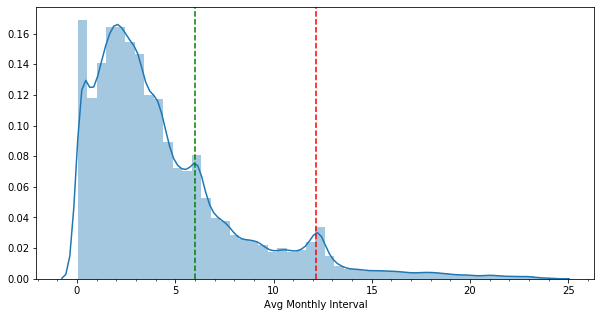

In [494]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.distplot(customer['Avg Monthly Interval'].dropna())
per95 = np.quantile(np.array(customer['Avg Monthly Interval'].dropna()),.94)
per75 = np.quantile(np.array(customer['Avg Monthly Interval'].dropna()),.75)
plt.axvline(per95, color="r", linestyle="--")
plt.axvline(per75, color="g", linestyle="--")
ax.xaxis.set_minor_locator(MultipleLocator(1))
#print(np.quantile(np.array(customer['Avg Interval'].dropna()),.75))
#print(np.quantile(np.array(customer['Avg Interval'].dropna()),.94))
per6 = '%.1f'%(stats.percentileofscore(customer['Avg Interval'].dropna(), 180))
per12 = '%.1f'%(stats.percentileofscore(customer['Avg Interval'].dropna(), 365))
print('The green line shows that '+per6+ '% of the customers have an average interval of 6 months, and\n the red line indicates that', per12+ '% of the customers have an average interval of 12 months.')

In [194]:
customerData = pd.read_csv('Customer Data.csv')

# Label Churn using 12-month threshold and non-churn using 6-month

Through the testing results at the back of the code, using 12-month threshold for labelling churn and 6-month for non-churn give the highest accuracies

In [141]:
# orders with valid sales transactions, no returned orders
purchases = df1Clean[(df1Clean['Sales'] > 0)]
order = purchases[['Customer Name', 'Order Number', 'Order Channel', 'Order Store', 'Order Store Zip', 
                   'Ship Channel', 'Ship Store', 'Ship Store Zip', 'Department', 'Product Category']]

In [31]:
# first transaction date 2019-04-02
print(min(df1['Order Date']))
max(df1['Order Date'])
# last transaction date

2019-04-02


'2021-03-29'

In [357]:
purchases['Customer Name'].drop_duplicates()
#573446 customers total
#566019 customers made valid puchases

0              Customer 1
16            Customer 10
24           Customer 100
26          Customer 1000
29         Customer 10000
                ...      
4957847    Customer 99995
4957871    Customer 99996
4957915    Customer 99997
4957917    Customer 99998
4957921    Customer 99999
Name: Customer Name, Length: 566019, dtype: object

In [142]:
# find the lastest order date for each customer
lastOrder=purchases.sort_values(['Customer Name','Order Date'],ascending=False).drop_duplicates('Customer Name')[['Customer Name','Order Date']]

# set 'Customer Name' as index for last_order df to effciently look for customers by conditions
lastOrder.index=lastOrder['Customer Name']

# find number of orders each customer placed by counting unique values of 'Order Date'
numOrders = purchases.groupby('Customer Name').agg({'Order Date': "nunique"}).sort_values('Order Date')

# 278297 customers ordered only once during the whole period
one = numOrders[numOrders['Order Date']==1].index.to_list()
numOrders=numOrders.rename(columns = {'Order Date':'Num of Purchases'})
len(one)

278297

In [229]:
one=numOrders[numOrders['Num of Purchases']==1]
one.merge(label, left_index=True, right_index=True, how = 'inner')
# 136512 one-time customers labelled as churn

,Num of Purchases,Customer Zip,Customer Age,Customer Children,Sales Returned Avg,Cost Returned Avg,Gross Profit Returned Avg,Qty Returned Avg,Sales Made Avg,Cost Made Avg,Gross Profit Made Avg,Qty Made Avg,Profit Margin,Profitability,Ship Channel 2,Ship Channel 3,Ship Channel 4,Ship Channel 5,Ship Channel 6,Ship Store 10,Ship Store 100,Ship Store 101,Ship Store 102,Ship Store 103,Ship Store 104,Ship Store 105,Ship Store 106,Ship Store 107,Ship Store 108,Ship Store 109,Ship Store 11,Ship Store 110,Ship Store 111,Ship Store 112,Ship Store 113,Ship Store 114,Ship Store 115,Ship Store 116,Ship Store 117,Ship Store 118,Ship Store 119,Ship Store 12,Ship Store 120,Ship Store 121,Ship Store 13,Ship Store 14,Ship Store 15,Ship Store 16,Ship Store 17,Ship Store 18,...,Customer Segment 49,Customer Segment 5,Customer Segment 50,Customer Segment 51,Customer Segment 52,Customer Segment 53,Customer Segment 54,Customer Segment 55,Customer Segment 56,Customer Segment 57,Customer Segment 58,Customer Segment 59,Customer Segment 6,Customer Segment 60,Customer Segment 61,Customer Segment 62,Customer Segment 63,Customer Segment 64,Customer Segment 65,Customer Segment 66,Customer Segment 67,Customer Segment 68,Customer Segment 69,Customer Segment 7,Customer Segment 70,Customer Segment 71,Customer Segment 8,Customer Segment 9,Customer Group 10,Customer Group 11,Customer Group 12,Customer Group 13,Customer Group 14,Customer Group 15,Customer Group 16,Customer Group 17,Customer Group 18,Customer Group 19,Customer Group 2,Customer Group 3,Customer Group 4,Customer Group 5,Customer Group 6,Customer Group 7,Customer Group 8,Customer Group 9,Customer Gender 2,Customer Marital Status 2,Customer Marital Status 3,Churn
Customer 357643,1,4411.0,61.0,4.0,0.0,0.000,0.000,0.0,59.483,19.278,40.205,3.0,0.675907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Customer 288853,1,6328.0,15.0,4.0,-255.0,-62.305,-192.695,-6.0,648.329,180.489,467.840,15.0,0.721609,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
Customer 288852,1,6777.0,52.0,3.0,0.0,0.000,0.000,0.0,131.665,29.903,101.762,9.0,0.772886,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Customer 288844,1,6042.0,18.0,3.0,0.0,0.000,0.000,0.0,414.919,285.192,129.727,39.0,0.312656,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
Customer 288841,1,6059.0,15.0,1.0,0.0,0.000,0.000,0.0,135.150,31.297,103.853,6.0,0.768428,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [143]:
# customers placed first order in the recent 6 months
unlabel = lastOrder.loc[one,:][lastOrder.loc[one,:]['Order Date']>='2020-10-01'].sort_values('Order Date').index.to_list()

# unlabel customers placed first order in recent 6 months
lastOrder.drop(unlabel,axis=0,inplace=True)

# label churn for customers whose last orders were before the recent 12 months
# last orders in recent 6 months are non-churn, the rest are unlabelled
lastOrder['Churn']=lastOrder['Order Date'].apply(lambda x:1 if x<'2020-04-01' else 0 if x>='2020-10-01' else np.nan)

lastOrder.groupby('Churn').count()
# distribution of both classes for churn are balanced

,Customer Name,Order Date
Churn,,
0.0,183129,183129
1.0,186746,186746


In [304]:
# new customers whose first purchase happened within the past 6 months
len(unlabel)

88296

In [144]:
lastOrder=lastOrder.rename(columns = {'Order Date':'Last Order Date'}).drop(['Customer Name'], axis=1)

In [148]:
lastOrder.dropna(axis=0)
# 373482 labelled

,Last Order Date,Churn
Customer Name,,
Customer 99998,2020-03-27,1.0
Customer 99997,2019-11-27,1.0
Customer 99996,2021-03-21,0.0
Customer 99995,2020-12-01,0.0
Customer 99994,2020-03-16,1.0
...,...,...
Customer 100000,2020-02-18,1.0
Customer 10000,2021-03-24,0.0
Customer 1000,2019-07-18,1.0


# Feature Engineering

In [225]:
# convert age, zip, children to numeric variables
customer['Customer Age']=customer['Customer Age'].str[13::].astype(float)
customer['Customer Zip']=customer['Customer Zip'].str[13::].astype(float)
customer['Customer Children']=customer['Customer Children'].str[17::].astype(float)
#gross profit margin=profit/sales
customer['Profit Margin'] = customer['Gross Profit Made Avg']/abs(customer['Sales Made Avg'])
#label Profitability based on avg Gross Profit Made
customer['Profitability']=customer['Gross Profit Made Avg'].apply(lambda x:0 if x<=55 else 3 if x>=150 else 2 if x>55 and x<95 else 1)
#customer['Marginability']=customer['Profit Margin'].apply(lambda x:0 if x<=.56 else 3 if x>=.72 else 1 if x>.56 and x<=.65 else 2)

In [226]:
#customerDF = customer.drop(columns = ['Sales', 'Cost', 'Gross Profit', 'Qty', 'Last Order Date', 'First Order Date'])
customer.fillna(value = {'Sales Returned Avg':0, 'Cost Returned Avg':0, 'Gross Profit Returned Avg':0, 'Qty Returned Avg':0}, inplace=True)
#customerDF.fillna(value = {'Avg Interval': 1000}, inplace=True)
customer.describe().round(2)

,Customer Zip,Customer Age,Customer Children,Sales Returned Avg,Cost Returned Avg,Gross Profit Returned Avg,Qty Returned Avg,Sales Made Avg,Cost Made Avg,Gross Profit Made Avg,Qty Made Avg,Profit Margin,Profitability
count,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,566019.00,566019.00,566019.00,566019.00,566019.00,573446.00
mean,7906.92,31.82,2.54,-41.10,-13.92,-27.18,-1.22,180.15,63.36,116.79,6.89,0.63,1.50
std,5621.32,16.24,1.05,90.68,31.02,62.05,2.51,135.70,48.65,95.73,4.59,0.53,1.11
min,1.00,1.00,1.00,-4159.82,-1564.00,-2935.17,-120.00,0.08,-27.93,-361.39,-3.00,-308.40,0.00
25%,2526.00,18.00,2.00,-42.48,-14.99,-20.94,-3.00,87.89,30.46,55.15,3.00,0.57,1.00
50%,7074.00,32.00,3.00,0.00,0.00,0.00,0.00,150.43,51.82,94.89,6.00,0.66,1.00
75%,12423.00,44.00,3.00,0.00,0.00,0.00,0.00,232.44,82.25,150.62,9.00,0.72,2.00
max,19903.00,69.00,4.00,0.00,0.00,125.41,0.00,5038.44,1645.51,3392.93,418.50,3.41,3.00


In [155]:
# get dummy for order channel and store
orderInfo = order.sort_values(['Customer Name','Order Number']).drop_duplicates(['Customer Name','Order Number'])[['Customer Name','Order Number','Order Channel','Order Store']]
orderInfo = pd.get_dummies(data = orderInfo, prefix='', prefix_sep='', drop_first=True, 
               columns = ['Order Channel','Order Store'])
# get dummy for Ship Channel', 'Ship Store', 'Department', 'Product Category
dummy = pd.get_dummies(data = order, prefix='', prefix_sep='', drop_first=True, 
               columns = ['Ship Channel', 'Ship Store', 'Department', 'Product Category'])
categorical = dummy.groupby(['Customer Name','Order Number']).sum()
categorical.head()

Ship Channel 2  Ship Channel 3  \
Customer Name Order Number                                           
Customer 1    Order Number 1248752               1               0   
              Order Number 128642                0               0   
              Order Number 129006                0               0   
              Order Number 1304158               0               0   
              Order Number 133648                0               0   

                                    Ship Channel 4  Ship Channel 5  \
Customer Name Order Number                                           
Customer 1    Order Number 1248752               0               0   
              Order Number 128642                0               0   
              Order Number 129006                0               0   
              Order Number 1304158               0               0   
              Order Number 133648                0               0   

                                    Ship Channel 6  Ship Store 10  \
Customer Name Order Number                                          
Customer 1    Order Number 1248752               1              0   
              Order Number 128642                1              0   
              Order Number 129006                2              0   
              Order Number 1304158               0              0   
              Order Number 133648                1              0   

                                    Ship Store 100  Ship Store 101  \
Customer Name Order Number                                           
Customer 1    Order Number 1248752               0               0   
              Order Number 128642                0               0   
              Order Number 129006                0               0   
              Order Number 1304158               0               0   
              Order Number 133648                0               0   

                                    Ship Store 102  Ship Store 103  \
Customer Name Order Number                                           
Customer 1    Order Number 1248752               0               0   
              Order Number 128642                0               0   
              Order Number 129006                0               0   
              Order Number 1304158               0               0   
              Order Number 133648                0               0   

                                    Ship Store 104  Ship Store 105  \
Customer Name Order Number                                           
Customer 1    Order Number 1248752               0               0   
              Order Number 128642                0               0   
              Order Number 129006                0               0   
              Order Number 1304158               0               0   
              Order Number 133648                0               0   

                                    Ship Store 106  Ship Store 107  \
Customer Name Order Number                                           
Customer 1    Order Number 1248752               0               0   
              Order Number 128642                0               0   
              Order Number 129006                0               0   
              Order Number 1304158               0               0   
              Order Number 133648                0               0   

                                    Ship Store 108  Ship Store 109  \
Customer Name Order Number                                           
Customer 1    Order Number 1248752               0               0   
              Order Number 128642                0               0   
              Order Number 129006                0               0   
              Order Number 1304158               0               0   
              Order Number 133648                0               0   

                                    Ship Store 11  Ship Store 110  \
Customer Name Order Number                    

In [58]:
# aggregate the dummy variable by customers
orderInfo = orderInfo.groupby('Customer Name').sum()
categorical = categorical.groupby('Customer Name').sum()
orderDF = categorical.merge(orderInfo, left_index=True, right_index=True, how = 'outer')
orderDF.apply(lambda x:1 if x>1)
orderDF.head()

,Ship Channel 2,Ship Channel 3,Ship Channel 4,Ship Channel 5,Ship Channel 6,Ship Store 10,Ship Store 100,Ship Store 101,Ship Store 102,Ship Store 103,Ship Store 104,Ship Store 105,Ship Store 106,Ship Store 107,Ship Store 108,Ship Store 109,Ship Store 11,Ship Store 110,Ship Store 111,Ship Store 112,Ship Store 113,Ship Store 114,Ship Store 115,Ship Store 116,Ship Store 117,Ship Store 118,Ship Store 119,Ship Store 12,Ship Store 120,Ship Store 121,Ship Store 13,Ship Store 14,Ship Store 15,Ship Store 16,Ship Store 17,Ship Store 18,Ship Store 19,Ship Store 2,Ship Store 20,Ship Store 21,Ship Store 22,Ship Store 23,Ship Store 24,Ship Store 25,Ship Store 26,Ship Store 27,Ship Store 28,Ship Store 29,Ship Store 3,Ship Store 30,...,Order Store 53,Order Store 54,Order Store 55,Order Store 56,Order Store 57,Order Store 58,Order Store 59,Order Store 6,Order Store 60,Order Store 61,Order Store 62,Order Store 63,Order Store 64,Order Store 65,Order Store 66,Order Store 67,Order Store 68,Order Store 7,Order Store 70,Order Store 71,Order Store 72,Order Store 73,Order Store 74,Order Store 75,Order Store 76,Order Store 77,Order Store 78,Order Store 79,Order Store 8,Order Store 80,Order Store 81,Order Store 82,Order Store 83,Order Store 84,Order Store 85,Order Store 86,Order Store 87,Order Store 88,Order Store 89,Order Store 9,Order Store 90,Order Store 91,Order Store 92,Order Store 93,Order Store 94,Order Store 95,Order Store 96,Order Store 97,Order Store 98,Order Store 99
Customer Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Customer 1,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Customer 10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Customer 100,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Customer 1000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Customer 10000,1.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:
# change the sum score to dummy which represent 1 if a customer has ordered from a specifc channel or store
for co in orderDF.columns.to_list():
    orderDF[co]=orderDF[co].apply(lambda x:1 if x>1 else x)

In [158]:
orderDF.head()
#.to_csv('orderInfo.csv')

,Ship Channel 2,Ship Channel 3,Ship Channel 4,Ship Channel 5,Ship Channel 6,Ship Store 10,Ship Store 100,Ship Store 101,Ship Store 102,Ship Store 103,Ship Store 104,Ship Store 105,Ship Store 106,Ship Store 107,Ship Store 108,Ship Store 109,Ship Store 11,Ship Store 110,Ship Store 111,Ship Store 112,Ship Store 113,Ship Store 114,Ship Store 115,Ship Store 116,Ship Store 117,Ship Store 118,Ship Store 119,Ship Store 12,Ship Store 120,Ship Store 121,Ship Store 13,Ship Store 14,Ship Store 15,Ship Store 16,Ship Store 17,Ship Store 18,Ship Store 19,Ship Store 2,Ship Store 20,Ship Store 21,Ship Store 22,Ship Store 23,Ship Store 24,Ship Store 25,Ship Store 26,Ship Store 27,Ship Store 28,Ship Store 29,Ship Store 3,Ship Store 30,...,Order Store 53,Order Store 54,Order Store 55,Order Store 56,Order Store 57,Order Store 58,Order Store 59,Order Store 6,Order Store 60,Order Store 61,Order Store 62,Order Store 63,Order Store 64,Order Store 65,Order Store 66,Order Store 67,Order Store 68,Order Store 7,Order Store 70,Order Store 71,Order Store 72,Order Store 73,Order Store 74,Order Store 75,Order Store 76,Order Store 77,Order Store 78,Order Store 79,Order Store 8,Order Store 80,Order Store 81,Order Store 82,Order Store 83,Order Store 84,Order Store 85,Order Store 86,Order Store 87,Order Store 88,Order Store 89,Order Store 9,Order Store 90,Order Store 91,Order Store 92,Order Store 93,Order Store 94,Order Store 95,Order Store 96,Order Store 97,Order Store 98,Order Store 99
Customer Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Customer 1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Customer 10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Customer 100,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Customer 1000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Customer 10000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [227]:
customerDF = customer.merge(orderDF, left_index=True, right_index=True, how = 'outer')
customerDF = pd.get_dummies(customerDF, prefix='', prefix_sep='', drop_first=True, 
                            columns = ['Customer Residence Type','Customer Residence Unit', 
                                       'Customer Education', 'Customer Household Composition', 'Customer Homeowner', 
                                       'Customer Household Income', 'Customer Segment', 'Customer Group', 
                                       'Customer Gender', 'Customer Marital Status'])
customerDF.head()

,Customer Name,Customer Zip,Customer Age,Customer Children,Sales Returned Avg,Cost Returned Avg,Gross Profit Returned Avg,Qty Returned Avg,Sales Made Avg,Cost Made Avg,Gross Profit Made Avg,Qty Made Avg,Profit Margin,Profitability,Ship Channel 2,Ship Channel 3,Ship Channel 4,Ship Channel 5,Ship Channel 6,Ship Store 10,Ship Store 100,Ship Store 101,Ship Store 102,Ship Store 103,Ship Store 104,Ship Store 105,Ship Store 106,Ship Store 107,Ship Store 108,Ship Store 109,Ship Store 11,Ship Store 110,Ship Store 111,Ship Store 112,Ship Store 113,Ship Store 114,Ship Store 115,Ship Store 116,Ship Store 117,Ship Store 118,Ship Store 119,Ship Store 12,Ship Store 120,Ship Store 121,Ship Store 13,Ship Store 14,Ship Store 15,Ship Store 16,Ship Store 17,Ship Store 18,...,Customer Segment 48,Customer Segment 49,Customer Segment 5,Customer Segment 50,Customer Segment 51,Customer Segment 52,Customer Segment 53,Customer Segment 54,Customer Segment 55,Customer Segment 56,Customer Segment 57,Customer Segment 58,Customer Segment 59,Customer Segment 6,Customer Segment 60,Customer Segment 61,Customer Segment 62,Customer Segment 63,Customer Segment 64,Customer Segment 65,Customer Segment 66,Customer Segment 67,Customer Segment 68,Customer Segment 69,Customer Segment 7,Customer Segment 70,Customer Segment 71,Customer Segment 8,Customer Segment 9,Customer Group 10,Customer Group 11,Customer Group 12,Customer Group 13,Customer Group 14,Customer Group 15,Customer Group 16,Customer Group 17,Customer Group 18,Customer Group 19,Customer Group 2,Customer Group 3,Customer Group 4,Customer Group 5,Customer Group 6,Customer Group 7,Customer Group 8,Customer Group 9,Customer Gender 2,Customer Marital Status 2,Customer Marital Status 3
Customer Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Customer 1,Customer 1,10660.0,26.0,1.0,-149.671400,-66.3204,-83.351000,-4.2,167.843833,66.06200,101.781833,4.00,0.606408,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Customer 10,Customer 10,1514.0,24.0,3.0,0.000000,0.0000,0.000000,0.0,227.162500,50.10325,177.059250,6.75,0.779439,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
Customer 100,Customer 100,7121.0,33.0,2.0,0.000000,0.0000,0.000000,0.0,160.650000,44.93100,115.719000,6.00,0.720317,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Customer 1000,Customer 1000,10123.0,6.0,1.0,-280.500000,-101.5240,-178.976000,-3.0,447.950000,142.59600,305.354000,6.00,0.681670,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
Customer 10000,Customer 10000,1807.0,43.0,1.0,-244.865167,-84.4560,-160.409167,-6.5,253.351000,94.27350,159.077500,8.10,0.627894,3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [367]:
df2.to_csv('Dataset1_All_Customers.csv')

In [158]:
df2=pd.read_csv('Dataset1_customer.csv')
df2.describe().round(2)

,Customer Zip,Customer Age,Customer Children,Sales Returned Avg,Cost Returned Avg,Gross Profit Returned Avg,Qty Returned Avg,Sales Made Avg,Cost Made Avg,Gross Profit Made Avg,Qty Made Avg,Profit Margin,Profitability,Ship Channel 2,Ship Channel 3,Ship Channel 4,Ship Channel 5,Ship Channel 6,Ship Store 10,Ship Store 100,Ship Store 101,Ship Store 102,Ship Store 103,Ship Store 104,Ship Store 105,Ship Store 106,Ship Store 107,Ship Store 108,Ship Store 109,Ship Store 11,Ship Store 110,Ship Store 111,Ship Store 112,Ship Store 113,Ship Store 114,Ship Store 115,Ship Store 116,Ship Store 117,Ship Store 118,Ship Store 119,Ship Store 12,Ship Store 120,Ship Store 121,Ship Store 13,Ship Store 14,Ship Store 15,Ship Store 16,Ship Store 17,Ship Store 18,Ship Store 19,...,Customer Segment 48,Customer Segment 49,Customer Segment 5,Customer Segment 50,Customer Segment 51,Customer Segment 52,Customer Segment 53,Customer Segment 54,Customer Segment 55,Customer Segment 56,Customer Segment 57,Customer Segment 58,Customer Segment 59,Customer Segment 6,Customer Segment 60,Customer Segment 61,Customer Segment 62,Customer Segment 63,Customer Segment 64,Customer Segment 65,Customer Segment 66,Customer Segment 67,Customer Segment 68,Customer Segment 69,Customer Segment 7,Customer Segment 70,Customer Segment 71,Customer Segment 8,Customer Segment 9,Customer Group 10,Customer Group 11,Customer Group 12,Customer Group 13,Customer Group 14,Customer Group 15,Customer Group 16,Customer Group 17,Customer Group 18,Customer Group 19,Customer Group 2,Customer Group 3,Customer Group 4,Customer Group 5,Customer Group 6,Customer Group 7,Customer Group 8,Customer Group 9,Customer Gender 2,Customer Marital Status 2,Customer Marital Status 3
count,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,566019.00,566019.00,566019.00,566019.00,566019.00,573446.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.00,566019.0,...,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.0,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00
mean,7906.92,31.82,2.54,-41.10,-13.92,-27.18,-1.22,180.15,63.36,116.79,6.89,0.63,1.50,0.02,0.00,0.00,0.21,0.55,0.01,0.01,0.02,0.01,0.00,0.02,0.01,0.01,0.00,0.01,0.01,0.02,0.01,0.02,0.02,0.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.01,0.01,0.01,0.00,0.01,0.00,0.0,...,0.02,0.01,0.01,0.01,0.02,0.03,0.04,0.01,0.01,0.01,0.01,0.02,0.01,0.01,0.02,0.02,0.00,0.01,0.01,0.04,0.01,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.07,0.04,0.04,0.10,0.04,0.04,0.09,0.07,0.06,0.02,0.07,0.05,0.1,0.04,0.03,0.02,0.05,0.05,0.42,0.22,0.16
std,5621.32,16.24,1.05,90.68,31.02,62.05,2.51,135.70,48.65,95.73,4.59,0.53,1.11,0.13,0.03,0.01,0.40,0.50,0.09,0.10,0.13,0.10,0.06,0.12,0.09,0.10,0.05,0.08,0.12,0.13,0.10,0.14,0.13,0.03,0.12,0.11,0.10,0.10,0.11,0.11,0.08,0.09,0.04,0.11,0.09,0.12,0.06,0.11,0.06,0.0,...,0.12,0.12,0.09,0.11,0.14,0.16,0.21,0.09,0.11,0.11,0.11,0.13,0.08,0.10,0.14,0.14,0.04,0.07,0.08,0.19,0.09,0.15,0.11,0.11,0.11,0.12,0.10,0.12,0.13,0.26,0.19,0.19,0.31,0.20,0.20,0.28,0.25,0.24,0.16,0.26,0.21,0.3,0.18,0.17,0.15,0.21,0.22,0.49,0.41,0.36
min,1.00,1.00,1.00,-4159.82,-1564.00,-2935.17,-120.00,0.08,-27.93,-361.39,-3.00,-308.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.

In [162]:
df2.index=df2['Customer Name']
df2=df2.merge(lastOrder, left_index=True, right_index=True, how = 'left').drop(['Last Order Date','Customer Name.1'],axis=1)
unlabel = df2[df2.Churn.isnull()].drop(['Customer Name.1'],axis=1)
unlabel.shape

(203571, 420)

In [176]:
customerDF=pd.concat([customerDF,lastOrder], axis=1)
customerDF=customerDF.drop(['Last Order Date','Customer Name'],axis=1)
label=customerDF.dropna(subset=['Churn'], axis=0)
#label=label.iloc[:, :-1]
label.describe().round(2)

,Customer Zip,Customer Age,Customer Children,Sales Returned Avg,Cost Returned Avg,Gross Profit Returned Avg,Qty Returned Avg,Sales Made Avg,Cost Made Avg,Gross Profit Made Avg,Qty Made Avg,Profit Margin,Profitability,Ship Channel 2,Ship Channel 3,Ship Channel 4,Ship Channel 5,Ship Channel 6,Ship Store 10,Ship Store 100,Ship Store 101,Ship Store 102,Ship Store 103,Ship Store 104,Ship Store 105,Ship Store 106,Ship Store 107,Ship Store 108,Ship Store 109,Ship Store 11,Ship Store 110,Ship Store 111,Ship Store 112,Ship Store 113,Ship Store 114,Ship Store 115,Ship Store 116,Ship Store 117,Ship Store 118,Ship Store 119,Ship Store 12,Ship Store 120,Ship Store 121,Ship Store 13,Ship Store 14,Ship Store 15,Ship Store 16,Ship Store 17,Ship Store 18,Ship Store 19,...,Customer Segment 49,Customer Segment 5,Customer Segment 50,Customer Segment 51,Customer Segment 52,Customer Segment 53,Customer Segment 54,Customer Segment 55,Customer Segment 56,Customer Segment 57,Customer Segment 58,Customer Segment 59,Customer Segment 6,Customer Segment 60,Customer Segment 61,Customer Segment 62,Customer Segment 63,Customer Segment 64,Customer Segment 65,Customer Segment 66,Customer Segment 67,Customer Segment 68,Customer Segment 69,Customer Segment 7,Customer Segment 70,Customer Segment 71,Customer Segment 8,Customer Segment 9,Customer Group 10,Customer Group 11,Customer Group 12,Customer Group 13,Customer Group 14,Customer Group 15,Customer Group 16,Customer Group 17,Customer Group 18,Customer Group 19,Customer Group 2,Customer Group 3,Customer Group 4,Customer Group 5,Customer Group 6,Customer Group 7,Customer Group 8,Customer Group 9,Customer Gender 2,Customer Marital Status 2,Customer Marital Status 3,Churn
count,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.0,...,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.0,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.00,369875.0
mean,7817.25,31.90,2.54,-46.81,-15.97,-30.85,-1.40,184.53,64.83,119.70,7.04,0.63,1.55,0.02,0.00,0.00,0.21,0.60,0.01,0.01,0.02,0.01,0.01,0.02,0.01,0.01,0.00,0.01,0.02,0.02,0.01,0.02,0.02,0.00,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.01,0.01,0.02,0.00,0.01,0.00,0.0,...,0.01,0.01,0.01,0.02,0.03,0.05,0.01,0.01,0.01,0.01,0.02,0.01,0.01,0.02,0.02,0.00,0.00,0.01,0.03,0.01,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.07,0.04,0.04,0.11,0.04,0.04,0.09,0.07,0.06,0.02,0.07,0.05,0.1,0.03,0.03,0.02,0.05,0.05,0.41,0.21,0.15,0.5
std,5613.55,16.21,1.05,94.64,32.52,64.66,2.66,132.25,47.18,93.47,4.49,0.22,1.10,0.15,0.03,0.02,0.41,0.49,0.09,0.11,0.14,0.11,0.07,0.14,0.10,0.11,0.06,0.09,0.13,0.14,0.11,0.15,0.14,0.03,0.13,0.12,0.11,0.11,0.12,0.12,0.09,0.10,0.04,0.12,0.10,0.13,0.06,0.12,0.07,0.0,...,0.11,0.09,0.11,0.13,0.16,0.21,0.09,0.11,0.11,0.11,0.13,0.08,0.10,0.14,0.14,0.04,0.07,0.08,0.18,0.09,0.15,0.12,0.11,0.11,0.12,0.10,0.12,0.13,0.25,0.19,0.19,0.31,0.20,0.20,0.28,0.25,0.24,0.16,0.26,0.21,0.3,0.18,0.17,0.15,0.21,0.22,0.49,0.41,0.36,0.5
min,1.00,1.00,1.00,-4159.82,-1224.65,-2935.17,-120.00,0.34,0.00,-256.48,2.00,-36.93,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0

# Modelling

In [181]:
train,test=train_test_split(label, test_size=.3)

In [332]:
model_names = ["Logistic Regression", "Random Forest", "XgBoost"]
models = [LogisticRegression(), RandomForestClassifier(), XGBClassifier()]
# default parameters for rf: n_estimators=100, max_depth=None, min_samples_leaf=1

def model_predict(model, features_train, features_test, label_train, label_test):
    '''
    Make prediction on machine learning
    input:  model -- the model used to predict
            features_train -- the training data (x_train)
            features_test -- the testing data (x_test)
            labels_train -- the training labels (y_train)
            labels_test -- the testing labels (y_test)      
    return: the predicted values and probabilities
    '''
    #ml=model
    model.fit(features_train,label_train)
    pred1 = model.predict(features_train)
    prob1 = model.predict_proba(features_train)
    pred2 = model.predict(features_test)
    prob2 = model.predict_proba(features_test)
    #print(classification_report(labels_test,pred))
    return pred1, prob1, pred2, prob2, model

def roc_get_par(test, prob):
    '''
    get false positive and true positive score
    input:  test -- the true values
            prob -- predicted probilities
    return: a FP and TP rate list
    '''
    fpr, tpr, _  = roc_curve(test, prob[:,1])
    return [fpr, tpr] 

def evaluation(training, testing, target, models = models):
    '''
    print out the information of the input dataframe, including a plot of target values and descriptions   
    input:  training -- the training data
            testing -- the testing data
            target -- the name of the label
            var_group -- the names of feature groups (list)
            combine_var -- the names of feature groups and ml models (list)
            models -- models to use in the training        
    return: the result of prediction and the pars for ROC curve
    '''
    par = []
    md=[]
    acc_v = []
    acc_t1 = []
    acc_t2=[]
    au_v = []
    au_t1 = []
    au_t2 = []
    precision1 = []
    precision2 = []
    recall1 = []
    recall2 = []
    pred_train=[]
    prob_train=[]
    pred_test=[]
    prob_test=[]
    
    for model in models:
            pred1,prob1,pred2,prob2,model_fit = model_predict(model,
                                      training.loc[:,[i for i in training.columns.to_list() if i != target]],
                                      testing.loc[:,[i for i in training.columns.to_list() if i != target]],
                                      training[target],
                                      testing[target])        
            r2= roc_get_par(testing[target],prob2)
            r1= roc_get_par(training[target],prob1)
            au_t2.append(auc(r2[0],r2[1]))
            au_t1.append(auc(r1[0],r1[1]))
            acc_t1.append(accuracy_score(training[target],pred1))
            acc_t2.append(accuracy_score(testing[target],pred2))
            precision1.append(precision_score(training[target],pred1))
            precision2.append(precision_score(testing[target],pred2))
            recall1.append(recall_score(training[target],pred1))
            recall2.append(recall_score(testing[target],pred2))
            par.append(r2)
            pred_train.append(pred1)
            pred_test.append(pred2)
            prob_train.append(prob1[:,1])
            prob_test.append(prob2[:,1])
            md.append(model_fit)
            '''        
            cv = cross_validate(model, 
                                 training.loc[:,[i for i in training.columns.to_list() if i != target]], 
                                 training[target], 
                                 cv=5,
                                 scoring=('accuracy', 'roc_auc'),
                                 return_train_score=True)
            acc_v.append(cv['test_accuracy'].mean())
            au_v.append(cv['test_roc_auc'].mean())
            '''
            print('--------------------------')
        
    result_df = {'Model': model_names,
                 'Training Accuracy':acc_t1,
                 'Test Accuracy':acc_t2,
                 #'cross_v_accuracy':acc_v,
                 #'cross_v_auc':au_v,
                 'Train AUC':au_t1,
                 'Test AUC':au_t2,
                 #'train_precision':precision1,
                 'Precision':precision2,
                 #'train_recall':recall1,
                 'Recall':recall2} 
    return pd.DataFrame(result_df), par, md

def cm_plt(md, label_test, feature_test, model_names = model_names):
    colors = ["BuGn", "Purples", 'Blues']
    for n,i in enumerate(model_names):
        pred_test=md[n].predict(feature_test)
        cf_matrix = confusion_matrix(list(label_test), list(pred_test))
        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        fig, ax = plt.subplots(figsize=(8, 5))
        sns.set(font_scale=1.4)
        b=sns.heatmap(cf_matrix, annot=labels,annot_kws={"size": 16}, fmt='', cmap=colors[n])
        b.axes.set_title(i,fontsize=20)
        b.set_xlabel("Predicted Label",fontsize=16)
        b.set_ylabel("True Label",fontsize=16)
        ax.set_ylim([2,0])

def roc_plt(par, model_names = model_names):          
    plt.figure(figsize=(10, 5))
    plt.plot([0, 1], [0, 1], 'k--')    
    n=0
    for i in range(3):
        plt.plot(par[i][0], 
                 par[i][1], 
                 label=model_names[i])
    plt.xlabel('False Positive Rate (1-Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

In [252]:
result_def_all, par_def_all, model_fit_def= evaluation(train, test, 'Churn')

--------------------------
--------------------------
--------------------------


In [368]:
result_def_all.round(4) #.sort_values('test_auc',ascending = False)

,variable_model,train_accuracy,test_accuracy,train_auc,test_auc,test_precision,test_recall
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.6498,0.6486,0.6989,0.6982,0.6227,0.7684
1,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",1.0000,0.8254,1.0000,0.9035,0.8437,0.8023
2,"XGBClassifier(base_score=0.5, booster=None, co...",0.8423,0.8341,0.9251,0.9151,0.8425,0.8252


In [362]:
df2.fillna(0, inplace=True)
# predict churn probability
proba=model_fit_def[2].predict_proba(df2.drop('Churn',axis=1))
df2['Probability']=proba[:,1]
# predict churn
unlabel['Churn'] = model_fit_def[2].predict(unlabel.drop('Churn',axis=1))
df2['Churn']=df2['Churn'].combine_first(unlabel['Churn'])
df2.describe().round(2)

,Customer Zip,Customer Age,Customer Children,Sales Returned Avg,Cost Returned Avg,Gross Profit Returned Avg,Qty Returned Avg,Sales Made Avg,Cost Made Avg,Gross Profit Made Avg,Qty Made Avg,Profit Margin,Profitability,Ship Channel 2,Ship Channel 3,Ship Channel 4,Ship Channel 5,Ship Channel 6,Ship Store 10,Ship Store 100,Ship Store 101,Ship Store 102,Ship Store 103,Ship Store 104,Ship Store 105,Ship Store 106,Ship Store 107,Ship Store 108,Ship Store 109,Ship Store 11,Ship Store 110,Ship Store 111,Ship Store 112,Ship Store 113,Ship Store 114,Ship Store 115,Ship Store 116,Ship Store 117,Ship Store 118,Ship Store 119,Ship Store 12,Ship Store 120,Ship Store 121,Ship Store 13,Ship Store 14,Ship Store 15,Ship Store 16,Ship Store 17,Ship Store 18,Ship Store 19,...,Customer Segment 49,Customer Segment 5,Customer Segment 50,Customer Segment 51,Customer Segment 52,Customer Segment 53,Customer Segment 54,Customer Segment 55,Customer Segment 56,Customer Segment 57,Customer Segment 58,Customer Segment 59,Customer Segment 6,Customer Segment 60,Customer Segment 61,Customer Segment 62,Customer Segment 63,Customer Segment 64,Customer Segment 65,Customer Segment 66,Customer Segment 67,Customer Segment 68,Customer Segment 69,Customer Segment 7,Customer Segment 70,Customer Segment 71,Customer Segment 8,Customer Segment 9,Customer Group 10,Customer Group 11,Customer Group 12,Customer Group 13,Customer Group 14,Customer Group 15,Customer Group 16,Customer Group 17,Customer Group 18,Customer Group 19,Customer Group 2,Customer Group 3,Customer Group 4,Customer Group 5,Customer Group 6,Customer Group 7,Customer Group 8,Customer Group 9,Customer Gender 2,Customer Marital Status 2,Customer Marital Status 3,Churn
count,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.0,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.0,...,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.0,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00,573446.00
mean,7906.92,31.82,2.54,-41.10,-13.92,-27.18,-1.22,177.82,62.54,115.28,6.80,0.62,1.50,0.02,0.00,0.00,0.2,0.54,0.01,0.01,0.02,0.01,0.00,0.02,0.01,0.01,0.00,0.01,0.01,0.02,0.01,0.02,0.02,0.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.01,0.01,0.01,0.00,0.01,0.00,0.0,...,0.01,0.01,0.01,0.02,0.03,0.04,0.01,0.01,0.01,0.01,0.02,0.01,0.01,0.02,0.02,0.00,0.01,0.01,0.04,0.01,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.07,0.04,0.04,0.10,0.04,0.04,0.09,0.07,0.06,0.02,0.07,0.05,0.1,0.04,0.03,0.02,0.05,0.05,0.42,0.22,0.16,0.60
std,5621.32,16.24,1.05,90.68,31.02,62.05,2.51,136.34,48.86,96.02,4.63,0.53,1.11,0.13,0.03,0.01,0.4,0.50,0.09,0.10,0.13,0.09,0.06,0.12,0.09,0.10,0.05,0.08,0.12,0.12,0.10,0.13,0.13,0.03,0.12,0.11,0.10,0.10,0.11,0.11,0.08,0.09,0.04,0.11,0.09,0.12,0.06,0.11,0.06,0.0,...,0.12,0.09,0.11,0.14,0.16,0.21,0.09,0.11,0.11,0.11,0.13,0.08,0.10,0.14,0.14,0.04,0.07,0.08,0.19,0.09,0.15,0.11,0.11,0.11,0.12,0.10,0.12,0.13,0.26,0.19,0.19,0.31,0.20,0.20,0.28,0.25,0.24,0.16,0.26,0.21,0.3,0.18,0.17,0.15,0.21,0.22,0.49,0.41,0.36,0.49
min,1.00,1.00,1.00,-4159.82,-1564.00,-2935.17,-120.00,0.00,-27.93,-361.39,-3.00,-308.40,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,

In [369]:
df2[['Churn','Probability']].to_csv('Predicted Churn Results.csv')

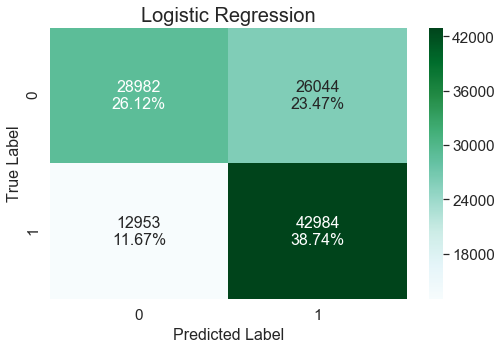

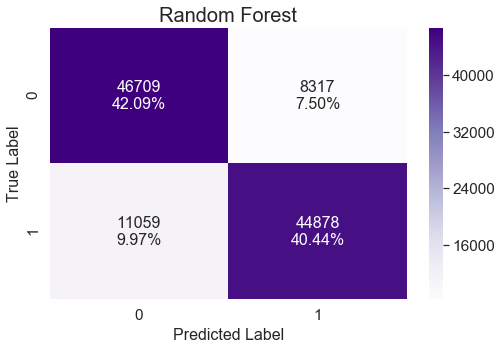

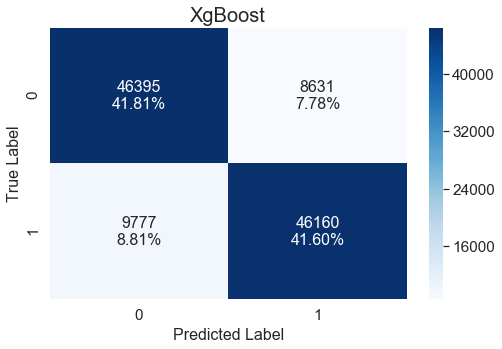

In [333]:
cm_plt(model_fit_def,test['Churn'],test.drop('Churn',axis=1))

In [206]:
lr=LogisticRegression()
lr.fit(train.drop(['Churn'], axis=1),train['Churn'])

predict = lr.predict(train.drop(['Churn'], axis=1))
trainAcc = accuracy_score(train['Churn'],predict)
predict = lr.predict(test.drop(['Churn'], axis=1))
testAcc = accuracy_score(test['Churn'],predict)
lrPrecision = precision_score(test['Churn'],predict)
lrRecall = recall_score(test['Churn'],predict)
print(trainAcc,testAcc,lrPrecision,lrRecall)

C:\Users\yongl\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7092293906810035 0.7106422861674613 0.7108979670998113 0.7196016490871124


In [207]:
rf=RandomForestClassifier()
rf.fit(train.drop(['Churn'], axis=1),train['Churn'])

predict = rf.predict(train.drop(['Churn'], axis=1))
trainAcc = accuracy_score(train['Churn'],predict)
predict = rf.predict(test.drop(['Churn'], axis=1))
testAcc = accuracy_score(test['Churn'],predict)
rfPrecision = precision_score(test['Churn'],predict)
rfRecall = recall_score(test['Churn'],predict)
print(trainAcc,testAcc,rfPrecision,rfRecall)

1.0 0.8243648783828844 0.8421535580524344 0.8026092698684657


In [208]:
rf_feature=pd.DataFrame({'Features':train.drop(['Churn'], axis=1).columns.to_list(),'Importance':list(rf.feature_importances_)}).sort_values('Importance',ascending=False)
rf_feature[:20:]
# Top 20 important features by random forest model

,Features,Importance
10,Qty Made Avg,0.064594
161,Product Category 6,0.044485
8,Cost Made Avg,0.039196
7,Sales Made Avg,0.038369
11,Profit Margin,0.036890
9,Gross Profit Made Avg,0.032763
155,Product Category 18,0.030180
18,Ship Channel 6,0.029555
0,Customer Zip,0.025318
156,Product Category 19,0.024484


In [243]:
rf_feature.to_csv('feature importance.csv')

In [214]:
# hyper-parameter tunning: set max_depth to around n where (2^n >= # records in training set)
# increase max_depth and reduce min_samples_leaf to see if improved
rf=RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=2)
rf.fit(train.drop(['Churn'], axis=1),train['Churn'])

predict = rf.predict(train.drop(['Churn'], axis=1))
trainAcc = accuracy_score(train['Churn'],predict)
predict = rf.predict(test.drop(['Churn'], axis=1))
testAcc = accuracy_score(test['Churn'],predict)
rfPrecision = precision_score(test['Churn'],predict)
rfRecall = recall_score(test['Churn'],predict)
print(trainAcc,testAcc,rfPrecision,rfRecall)

0.8529114139166976 0.81474004848463 0.8166869018711612 0.8163516624725599


In [215]:
xgb=XGBClassifier()
xgb.fit(train.drop(['Churn'], axis=1),train['Churn'])
predict = xgb.predict(train.drop(['Churn'], axis=1))
trainAcc = accuracy_score(train['Churn'],predict)
predict = xgb.predict(test.drop(['Churn'], axis=1))
testAcc = accuracy_score(test['Churn'],predict)
xgbPrecision = precision_score(test['Churn'],predict)
xgbRecall = recall_score(test['Churn'],predict)
print(trainAcc,testAcc,xgbPrecision,xgbRecall)

0.8426608268446422 0.8331335670448708 0.842922174079965 0.8228837607752851


In [182]:
xgb=XGBClassifier()
xgb.fit(train.drop(['Churn'], axis=1),train['Churn'])
predictTrain = xgb.predict(train.drop(['Churn'], axis=1))
trainAcc = accuracy_score(train['Churn'],predictTrain)
predictTest = xgb.predict(test.drop(['Churn'], axis=1))
testAcc = accuracy_score(test['Churn'],predictTest)
xgbPrecision = precision_score(test['Churn'],predictTest)
xgbRecall = recall_score(test['Churn'],predictTest)
print(trainAcc,testAcc,xgbPrecision,xgbRecall)

0.8423170807069583 0.8341068644503122 0.8424741289627858 0.8252140801258558


In [237]:
report=classification_report(test['Churn'],predictTest, output_dict=True)
reportDF = pd.DataFrame(report).round(4)
reportDF

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.8259,0.8425,0.8341,0.8342,0.8343
recall,0.8431,0.8252,0.8341,0.8342,0.8341
f1-score,0.8345,0.8338,0.8341,0.8341,0.8341
support,55026.0000,55937.0000,0.8341,110963.0000,110963.0000


In [191]:
# use XGB to predict unlabelled customers
# model.predict_proba to give probability results
# roc_auc_score 
preUnlabel=xgb.predict(unlabel.drop(['Churn'], axis=1))
dfUnlabel=pd.DataFrame(preUnlabel,columns=['churn'])
dfUnlabel.describe().round(2)

,churn
count,203571.00
mean,0.77
std,0.42
min,0.00
25%,1.00
50%,1.00
75%,1.00
max,1.00


In [197]:
print(dfUnlabel[dfUnlabel.churn==1].count())
203571-156924
# for unlabeled customers, 156924 labelled as churn and 46647 labelled as non-churn

churn    156924
dtype: int64


46647

In [244]:
xgb_feature=pd.DataFrame({'Features':train.drop(['Churn'], axis=1).columns.to_list(),'Importance':list(xgb.feature_importances_)}).sort_values('Importance',ascending=False)
xgb_feature[:20:]
# Top 20 important features by XGBoost model

,Features,Importance
161,Product Category 6,0.174914
155,Product Category 18,0.067902
156,Product Category 19,0.058421
54,Ship Store 22,0.031736
18,Ship Channel 6,0.029462
197,Order Store 18,0.026822
17,Ship Channel 5,0.026577
10,Qty Made Avg,0.025208
162,Product Category 7,0.024359
139,Department 2,0.019431


In [245]:
xgb_feature.to_csv('XGB feature importance.csv')

In [141]:
cv = cross_validate(RandomForestClassifier(),train.drop(['Churn'], axis=1),train['Churn'],
                     cv=5,
                     scoring=('accuracy', 'roc_auc'),
                     return_train_score=True)
print(cv['test_accuracy'].mean(), cv['test_roc_auc'].mean())

0.8898583253257882 0.9715461365620996


In [142]:
cv = cross_validate(RandomForestClassifier(), customerDF.drop(['Churn'], axis=1), customerDF['Churn'], cv=5,
                     scoring=('accuracy', 'roc_auc'),
                     return_train_score=True)
print(cv['test_accuracy'].mean(), cv['test_roc_auc'].mean())

0.8486786076377155 0.9772183949169368


In [144]:
cvLR = cross_validate(LogisticRegression(), customerDF.drop(['Churn'], axis=1), customerDF['Churn'], cv=5,
                     scoring=('accuracy', 'roc_auc'),
                     return_train_score=True)
print(cvLR['test_accuracy'].mean(), cvLR['test_roc_auc'].mean())

C:\Users\yongl\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\yongl\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

0.8531855356539371 0.9758185587195157


# Label for profitability using avg gross profit

0 (<=24), 1 (24-40), 2 (40-60), 3 (>=60)

In [371]:
avgProfit = df1.groupby('Customer Name')['Gross Profit'].mean()
customer['Average Profit'] = avgProfit

In [369]:
customer['Profit Log'] = np.log(customer['Gross Profit'])

In [172]:
customer.describe().round(2)

,Customer Age,Customer Children,Sales Returned Avg,Cost Returned Avg,Gross Profit Returned Avg,Qty Returned Avg,Sales Made Avg,Cost Made Avg,Gross Profit Made Avg,Qty Made Avg,Profit Margin,Profitability,Marginability
count,573446.00,573446.00,150210.00,150210.00,150210.00,150210.00,566019.00,566019.00,566019.00,566019.00,566019.00,573446.00,573446.00
mean,31.82,2.54,-156.89,-53.13,-103.76,-4.64,180.15,63.36,116.79,6.89,0.63,1.50,1.58
std,16.24,1.05,115.01,39.89,82.16,2.85,135.70,48.65,95.73,4.59,0.53,1.11,1.09
min,1.00,1.00,-4159.82,-1564.00,-2935.17,-120.00,0.08,-27.93,-361.39,-3.00,-308.40,0.00,0.00
25%,18.00,2.00,-194.99,-65.16,-131.10,-6.00,87.89,30.46,55.15,3.00,0.57,1.00,1.00
50%,32.00,3.00,-130.46,-42.84,-84.77,-3.00,150.43,51.82,94.89,6.00,0.66,1.00,2.00
75%,44.00,3.00,-81.99,-27.91,-51.34,-3.00,232.44,82.25,150.62,9.00,0.72,2.00,3.00
max,69.00,4.00,-0.53,0.00,125.41,-3.00,5038.44,1645.51,3392.93,418.50,3.41,3.00,3.00


In [351]:
customer[customer['Churn'] == 0].describe().round(2)

,Churn,Order Date,Sales,Cost,Gross Profit,Qty,Sales Returned,Cost Returned,Gross Profit Returned,Qty Returned,Sales Made,Cost Made,Gross Profit Made,Qty Made,Average Profit,Profitability
count,183129.0,183129.00,183129.00,183129.00,183129.00,183129.00,80388.00,80388.00,80388.00,80388.00,183129.00,183129.00,183129.00,183129.00,183129.00,183129.00
mean,0.0,5.54,1131.96,422.85,709.12,45.17,-423.73,-147.89,-275.84,-12.54,1304.92,477.09,827.83,49.44,43.13,1.51
std,0.0,5.94,1545.19,647.86,995.65,62.89,667.44,244.51,437.24,18.90,1807.19,719.36,1167.61,67.86,25.50,1.05
min,0.0,2.00,-11894.39,-2827.52,-36178.11,-108.00,-27437.51,-9386.29,-18903.37,-615.00,2.35,0.65,-2097.94,6.00,-113.34,0.00
25%,0.0,2.00,348.06,126.99,207.60,15.00,-469.96,-162.44,-307.77,-15.00,390.15,141.10,235.77,15.00,25.71,1.00
50%,0.0,4.00,669.38,248.74,411.81,27.00,-219.30,-75.52,-140.53,-6.00,752.23,274.92,467.81,30.00,38.20,2.00
75%,0.0,7.00,1328.53,492.24,834.11,54.00,-110.50,-37.57,-67.61,-3.00,1517.57,552.21,963.49,57.00,55.34,2.00
max,0.0,236.00,65288.50,47981.07,44414.01,4002.00,-0.53,0.00,126.99,-3.00,68848.27,37737.38,47312.38,3135.00,651.10,3.00


In [352]:
customer[customer['Churn'] == 1].describe().round(2)
#customer = pd.read_csv('Customer Data.csv')

,Churn,Order Date,Sales,Cost,Gross Profit,Qty,Sales Returned,Cost Returned,Gross Profit Returned,Qty Returned,Sales Made,Cost Made,Gross Profit Made,Qty Made,Average Profit,Profitability
count,186746.0,186746.00,186746.00,186746.00,186746.00,186746.00,29915.00,29915.00,29915.00,29915.00,186746.00,186746.00,186746.00,186746.00,186746.00,186746.00
mean,1.0,1.44,233.50,80.85,152.65,9.15,-200.91,-66.64,-134.27,-5.91,262.17,89.45,172.72,9.85,50.44,1.60
std,0.0,0.99,284.40,107.63,193.74,10.69,207.35,71.62,144.74,5.39,321.47,117.39,219.36,11.35,38.59,1.15
min,1.0,1.00,-2101.17,-596.87,-4721.34,-33.00,-4395.43,-1649.95,-3279.33,-183.00,0.34,0.00,-666.18,3.00,-188.04,0.00
25%,1.0,1.00,79.90,24.77,48.33,3.00,-243.10,-79.08,-162.81,-6.00,83.28,27.66,54.62,3.00,24.82,1.00
50%,1.0,1.00,151.30,49.71,97.70,6.00,-142.80,-45.08,-93.99,-3.00,165.75,54.09,107.68,6.00,42.32,2.00
75%,1.0,2.00,283.70,98.77,185.15,12.00,-81.60,-27.02,-51.55,-3.00,310.23,107.54,205.03,12.00,66.25,3.00
max,1.0,65.00,13975.26,7619.48,8006.18,516.00,-2.55,0.00,124.13,-3.00,13975.26,6151.04,8120.34,609.00,979.88,3.00


In [353]:
pd.crosstab(customer['Churn'], customer['Profitability']).apply(lambda x: x/x.sum(), axis=1).round(3)

Profitability,0,1,2,3
Churn,,,,
0.0,0.217,0.263,0.315,0.204
1.0,0.237,0.231,0.225,0.306


In [391]:
labeled = pd.crosstab(customer['Churn'], customer['Marginability']).sum().sum()
distr=pd.crosstab(customer['Churn'], customer['Marginability'])/labeled
distr.loc['Total']=distr.sum()
distr['Total'] = distr.sum(axis=1)
distr.round(3)

Marginability,0,1,2,3,Total
Churn,,,,,
0.0,0.120,0.155,0.145,0.075,0.495
1.0,0.115,0.105,0.120,0.165,0.505
Total,0.235,0.261,0.265,0.239,1.000


In [378]:
totalLabeled = pd.crosstab(customer['Churn'], customer['Profitability']).sum().sum()
distribution=pd.crosstab(customer['Churn'], customer['Profitability'])/totalLabeled
distribution.loc['Total']=distribution.sum()
distribution['Total'] = distribution.sum(axis=1)
distribution.round(3)

Profitability,0,1,2,3,Total
Churn,,,,,
0.0,0.117,0.147,0.130,0.101,0.495
1.0,0.127,0.106,0.116,0.155,0.505
Total,0.244,0.253,0.247,0.256,1.000


# Test different thresholds for labelling churn (6-month)

In [210]:
#select the first 15-month data as training set and use the rest as testing to check for 6-month threshold
training=purchases[purchases['Order Date'].between('2019-04-02', '2020-06-30')]
# customers who ordered in the first 15 months
training['Customer Name'].drop_duplicates()

0              Customer 1
16            Customer 10
24           Customer 100
26          Customer 1000
29         Customer 10000
                ...      
4957847    Customer 99995
4957871    Customer 99996
4957915    Customer 99997
4957917    Customer 99998
4957921    Customer 99999
Name: Customer Name, Length: 407274, dtype: object

In [211]:
# find the latest order date for each customer
last_order=training.sort_values(['Customer Name','Order Date'],ascending=False).drop_duplicates('Customer Name')[['Customer Name','Order Date']]

# set 'Customer Name' as index for last_order df to effciently look for customers by conditions
last_order.index=last_order['Customer Name']

# find number of orders each customer placed by counting unique values of 'Order Date'
num=training.groupby('Customer Name').agg({'Order Date': "nunique"}).sort_values('Order Date')

# 216997 customers ordered only once during the 15 months
once=num[num['Order Date']==1].index.to_list()
len(once)

216997

In [ ]:
# customers placed first order in the recent 6 months
delete=last_order.loc[once,:][last_order.loc[once,:]['Order Date']>='2020-01-01'].sort_values('Order Date').index.to_list()

# get rid of customers placed first order in recent 6 months for labeling
last_order.drop(delete,axis=0,inplace=True)

# label churn for customers whose last orders were before the recent 6 months, others are unchurned
last_order['label']=last_order['Order Date'].apply(lambda x:1 if x<'2020-01-01' else 0)

last_order.groupby('label').count()
# Customer Churn Distribution is balanced

In [270]:
# customers labelled as churn
labeledChurn = last_order[last_order.label == 1].index.to_list()

In [271]:
# customers ordered in the recent 9 months
testing = purchases[purchases['Order Date'].between('2020-07-01', '2021-03-29')]
testCustomer = testing['Customer Name'].drop_duplicates().to_list()

In [272]:
# number of customers labeled as churn but made purchases in recent 9 months
unchurn1 = []
for i in labeledChurn:
    if i in testCustomer:
        unchurn1.append(i)
len(unchurn1)/len(labeledChurn)
# 29.7% labeled as churned in fact did not churn (6-month)

0.2969619724496482

In [ ]:
training[training['Customer Name'].isin(unchurn1)].groupby('Department').count()

In [ ]:
training.groupby('Department').count()

In [273]:
# customers labelled as unchurn
labeledUnchurn = last_order[last_order.label == 0].index.to_list()

In [274]:
# number of customers labeled as unchurn but did not make purchases in recent 9 months
churn0 = 0
for i in labeledUnchurn:
    if i not in testCustomer:
        churn0+=1
churn0/len(labeledUnchurn)
#.34 (6 month)

0.340371411757013

# Test different thresholds for labelling churn (10-month)

In [6]:
#select the first 1 year data as training set and use the rest as testing to check for 10-month threshold
training1=purchases[purchases['Order Date'].between('2019-04-02', '2020-04-02')]
# customers who ordered in the first year
#training1['Customer Name'].drop_duplicates()

0              Customer 1
16            Customer 10
24           Customer 100
26          Customer 1000
29         Customer 10000
                ...      
4957847    Customer 99995
4957871    Customer 99996
4957915    Customer 99997
4957917    Customer 99998
4957921    Customer 99999
Name: Customer Name, Length: 370613, dtype: object

In [198]:
#select the first 15-month data as training set and use the rest as testing to check for 10-month threshold
training=purchases[purchases['Order Date'].between('2019-04-02', '2020-06-30')]

# find the latest order date for each customer
last_order=training.sort_values(['Customer Name','Order Date'],ascending=False).drop_duplicates('Customer Name')[['Customer Name','Order Date']]

# set 'Customer Name' as index for last_order df to effciently look for customers by conditions
last_order.index=last_order['Customer Name']

# find number of orders each customer placed by counting unique values of 'Order Date'
num=training.groupby('Customer Name').agg({'Order Date': "nunique"}).sort_values('Order Date')

# 216997 customers ordered only once during the first year
once=num[num['Order Date']==1].index.to_list()
len(once)

216997

In [199]:
# customers placed first order in the recent 10 months
delete=last_order.loc[once,:][last_order.loc[once,:]['Order Date']>='2019-09-01'].sort_values('Order Date').index.to_list()

# get rid of customers placed first order in recent 10 months for labeling
last_order.drop(delete,axis=0,inplace=True)

# label churn for customers whose last orders were before the recent 10 months, others are unchurned
last_order['label']=last_order['Order Date'].apply(lambda x:1 if x<'2019-09-01' else 0)

last_order.groupby('label').count()

,Customer Name,Order Date
label,,
0,179694,179694
1,60267,60267


In [200]:
# customers labelled as churn
labeledChurn = last_order[last_order.label == 1].index.to_list()

# customers labelled as unchurn
labeledUnchurn = last_order[last_order.label == 0].index.to_list()

In [201]:
# customers ordered in the recent 9 months
testing = purchases[purchases['Order Date'].between('2020-07-01', '2021-03-29')]
testCustomer = testing['Customer Name'].drop_duplicates().to_list()

In [171]:
# number of customers labeled as churn but made purchases
unchurn1 = []
for i in labeledChurn:
    if i in testCustomer:
        unchurn1.append(i)

len(unchurn1)/len(labeledChurn)

0.2521778087510578

In [202]:
# number of customers labeled as unchurn but did not make purchases
churn0 = 0
for i in labeledUnchurn:
    if i not in testCustomer:
        churn0+=1
churn0/len(labeledUnchurn)

0.3679922534976126

# Test different thresholds for labelling churn (8-month)

In [24]:
# find the latest order date for each customer
last_order=training1.sort_values(['Customer Name','Order Date'],ascending=False).drop_duplicates('Customer Name')[['Customer Name','Order Date']]

# set 'Customer Name' as index for last_order df to effciently look for customers by conditions
last_order.index=last_order['Customer Name']

# find number of orders each customer placed by counting unique values of 'Order Date'
num=training1.groupby('Customer Name').agg({'Order Date': "nunique"}).sort_values('Order Date')

# 204973 customers ordered only once during the first year
once=num[num['Order Date']==1].index.to_list()
len(once)

204973

In [195]:
#select the first 15-month data as training set and use the rest as testing to check for 6-month threshold
training=purchases[purchases['Order Date'].between('2019-04-02', '2020-06-30')]

# find the latest order date for each customer
last_order=training.sort_values(['Customer Name','Order Date'],ascending=False).drop_duplicates('Customer Name')[['Customer Name','Order Date']]

# set 'Customer Name' as index for last_order df to effciently look for customers by conditions
last_order.index=last_order['Customer Name']

# find number of orders each customer placed by counting unique values of 'Order Date'
num=training.groupby('Customer Name').agg({'Order Date': "nunique"}).sort_values('Order Date')

# 216997 customers ordered only once during the 15 months
once=num[num['Order Date']==1].index.to_list()

# customers placed first order in the recent 8 months
delete=last_order.loc[once,:][last_order.loc[once,:]['Order Date']>='2019-11-01'].sort_values('Order Date').index.to_list()

# get rid of customers placed first order in recent 10 months for labeling
last_order.drop(delete,axis=0,inplace=True)

# label churn for customers whose last orders were before the recent 8 months, others are unchurned
last_order['label']=last_order['Order Date'].apply(lambda x:1 if x<'2019-11-01' else 0)

last_order.groupby('label').count()

,Customer Name,Order Date
label,,
0,168132,168132
1,99189,99189


In [196]:
# customers labelled as churn
labeledChurn = last_order[last_order.label == 1].index.to_list()

# customers labelled as unchurn
labeledUnchurn = last_order[last_order.label == 0].index.to_list()

# customers ordered in the recent 9 months
testing = purchases[purchases['Order Date'].between('2020-07-01', '2021-03-29')]
testCustomer = testing['Customer Name'].drop_duplicates().to_list()

In [175]:
# number of customers labeled as churn but made purchases in the second year
unchurn1 = []
for i in labeledChurn:
    if i in testCustomer:
        unchurn1.append(i)

len(unchurn1)/len(labeledChurn)

0.2735182328685641

In [197]:
# number of customers labeled as unchurn but did not make purchases in the second year
churn0 = 0
for i in labeledUnchurn:
    if i not in testCustomer:
        churn0+=1
churn0/len(labeledUnchurn)

0.3548224014464825

# Test different thresholds for labelling churn (6-month)

In [177]:
#select the first 15-month data as training set and use the rest as testing to check for 6-month threshold
training=purchases[purchases['Order Date'].between('2019-04-02', '2020-06-30')]

# find the latest order date for each customer
last_order=training.sort_values(['Customer Name','Order Date'],ascending=False).drop_duplicates('Customer Name')[['Customer Name','Order Date']]

# set 'Customer Name' as index for last_order df to effciently look for customers by conditions
last_order.index=last_order['Customer Name']

# find number of orders each customer placed by counting unique values of 'Order Date'
num=training.groupby('Customer Name').agg({'Order Date': "nunique"}).sort_values('Order Date')

# 216997 customers ordered only once during the 15 months
once=num[num['Order Date']==1].index.to_list()
len(once)

# customers placed first order in the recent 6 months
delete=last_order.loc[once,:][last_order.loc[once,:]['Order Date']>='2020-01-01'].sort_values('Order Date').index.to_list()

# get rid of customers placed first order in recent 6 months for labeling
last_order.drop(delete,axis=0,inplace=True)

# label churn for customers whose last orders were before the recent 6 months, others are unchurned
last_order['label']=last_order['Order Date'].apply(lambda x:1 if x<'2020-01-01' else 0)

last_order.groupby('label').count()
# Customer Churn Distribution is balanced

,Customer Name,Order Date
label,,
0,152930,152930
1,138873,138873


In [178]:
# customers labelled as churn
labeledChurn = last_order[last_order.label == 1].index.to_list()

# customers labelled as unchurn
labeledUnchurn = last_order[last_order.label == 0].index.to_list()

# customers ordered in the recent 9 months
testing = purchases[purchases['Order Date'].between('2020-07-01', '2021-03-29')]
testCustomer = testing['Customer Name'].drop_duplicates().to_list()

In [179]:
# number of customers labeled as churn but made purchases in the second year
unchurn1 = []
for i in labeledChurn:
    if i in testCustomer:
        unchurn1.append(i)
len(unchurn1)/len(labeledChurn)

0.2969619724496482

In [180]:
# number of customers labeled as unchurn but did not make purchases in the second year
churn0 = 0
for i in labeledUnchurn:
    if i not in testCustomer:
        churn0+=1
churn0/len(labeledUnchurn)

0.340371411757013

# Test different thresholds for labelling churn (5-month)

In [135]:
#select the first 1 year data as training set and use the rest as testing to check for 10-month threshold
training1=purchases[purchases['Order Date'].between('2019-04-02', '2020-04-02')]
# customers who ordered in the first year
training1['Customer Name'].drop_duplicates()

0              Customer 1
16            Customer 10
24           Customer 100
26          Customer 1000
29         Customer 10000
                ...      
4957847    Customer 99995
4957871    Customer 99996
4957915    Customer 99997
4957917    Customer 99998
4957921    Customer 99999
Name: Customer Name, Length: 370613, dtype: object

In [191]:
#select the first 15-month data as training set and use the rest as testing to check for 6-month threshold
training=purchases[purchases['Order Date'].between('2019-04-02', '2020-06-30')]

# find the latest order date for each customer
last_order=training.sort_values(['Customer Name','Order Date'],ascending=False).drop_duplicates('Customer Name')[['Customer Name','Order Date']]

# set 'Customer Name' as index for last_order df to effciently look for customers by conditions
last_order.index=last_order['Customer Name']

# find number of orders each customer placed by counting unique values of 'Order Date'
num=training.groupby('Customer Name').agg({'Order Date': "nunique"}).sort_values('Order Date')

# 216997 customers ordered only once during the 15 months
once=num[num['Order Date']==1].index.to_list()
len(once)

216997

In [192]:
# customers placed first order in the recent 6 months
delete=last_order.loc[once,:][last_order.loc[once,:]['Order Date']>='2020-02-01'].sort_values('Order Date').index.to_list()

# get rid of customers placed first order in recent 6 months for labeling
last_order.drop(delete,axis=0,inplace=True)

# label churn for customers whose last orders were before the recent 5 months, others are unchurned
last_order['label']=last_order['Order Date'].apply(lambda x:1 if x<'2020-02-01' else 0)

last_order.groupby('label').count()
# Customer Churn Distribution is balanced

,Customer Name,Order Date
label,,
0,146386,146386
1,154040,154040


In [193]:
# customers labelled as churn
labeledChurn = last_order[last_order.label == 1].index.to_list()

# customers labelled as unchurn
labeledUnchurn = last_order[last_order.label == 0].index.to_list()

In [184]:
# number of customers labeled as churn but made purchases in the second year
unchurn1 = []
for i in labeledChurn:
    if i in testCustomer:
        unchurn1.append(i)

len(unchurn1)/len(labeledChurn)

0.3085402669564081

In [194]:
# number of customers labeled as unchurn but did not make purchases in the second year
churn0 = 0
for i in labeledUnchurn:
    if i not in testCustomer:
        churn0+=1
churn0/len(labeledUnchurn)

0.33566051398357766

# Test different thresholds for labelling churn (12-month)

In [186]:
#select the first 15-month data as training set and use the rest as testing to check for 6-month threshold
training=purchases[purchases['Order Date'].between('2019-04-02', '2020-06-30')]

# find the latest order date for each customer
last_order=training.sort_values(['Customer Name','Order Date'],ascending=False).drop_duplicates('Customer Name')[['Customer Name','Order Date']]

# set 'Customer Name' as index for last_order df to effciently look for customers by conditions
last_order.index=last_order['Customer Name']

# find number of orders each customer placed by counting unique values of 'Order Date'
num=training.groupby('Customer Name').agg({'Order Date': "nunique"}).sort_values('Order Date')

# 216997 customers ordered only once during the 15 months
once=num[num['Order Date']==1].index.to_list()
len(once)

216997

In [187]:
# customers placed first order in the recent months
delete=last_order.loc[once,:][last_order.loc[once,:]['Order Date']>='2019-07-01'].sort_values('Order Date').index.to_list()

# get rid of customers placed first order in recent 6 months for labeling
last_order.drop(delete,axis=0,inplace=True)

# label churn for customers whose last orders were before the recent months, others are unchurned
last_order['label']=last_order['Order Date'].apply(lambda x:1 if x<'2019-07-01' else 0)

last_order.groupby('label').count()

,Customer Name,Order Date
label,,
0,186227,186227
1,31955,31955


In [188]:
# customers labelled as churn
labeledChurn = last_order[last_order.label == 1].index.to_list()

# customers labelled as unchurn
labeledUnchurn = last_order[last_order.label == 0].index.to_list()

In [189]:
# number of customers labeled as churn but made purchases in the second year
unchurn1 = []
for i in labeledChurn:
    if i in testCustomer:
        unchurn1.append(i)

len(unchurn1)/len(labeledChurn)

0.23329682365826945

In [190]:
# number of customers labeled as unchurn but did not make purchases in the second year
churn0 = 0
for i in labeledUnchurn:
    if i not in testCustomer:
        churn0+=1
churn0/len(labeledUnchurn)

0.3766800732439442